# Comparing pRF predicted saliency to observed (fMRI betas) 



### Converting polar to cartesian coordinates

- Can then generate a 2D “image” which describes where each voxel “looks” at, in pixel space 
- Pointwise multiply/convolve the 2D image with the stimuli image(s) 
- This will tell how much *“Saliency drive”* each voxel is receiving for that stimuli image(s)


For example, for a `425 x 425 = 180625 px` image:

- Unravel the 2D image for each voxel to get a `voxels x 180625`. Multiplay with an image of `180625 x 1` . This resuls in a vector of size `voxels x 1`. Now we can correlate this vector **(Predicted)** to the Betas **(Observed)** generated from the fMRI experiment.


Similar to this operation:

$\underset{v\times 1}{\mathrm{\hat{Y}}} =  \underset{voxels \times 180,625}{K} \times \underset{180,625\times 1}{\textbf{x}} $

# Imports

In [1]:
import numpy as np
from scipy.misc import face
from scipy.ndimage import zoom
from scipy.special import logsumexp
import torch

import matplotlib.pyplot as plt
import math 

In [2]:
import h5py
import os
import sys
import struct
import time
import pandas as pd
from scipy.io import loadmat
from scipy import stats

In [3]:
import nibabel as nib
import nilearn
from nilearn import image
from nilearn import plotting 
from nilearn.image import math_img

from pathlib import Path
from nilearn.masking import apply_mask
from nilearn.maskers import NiftiMasker

import pandas as pd
import seaborn as sns
from tqdm import tqdm

%matplotlib inline

In [4]:
COCO_ROOT = '/gpfs01/bartels/user/hbhatnagar/coco/panoptic_annotations_trainval2017'
NSD_ROOT  = "/gpfs01/bartels/user/hbhatnagar/NSD_dataset/"
STIM_ROOT  = NSD_ROOT + "nsddata_stimuli/stimuli/nsd/"


stim_file = STIM_ROOT + "nsd_stimuli.hdf5"
exp_design_file = NSD_ROOT + "nsddata/experiments/nsd/nsd_expdesign.mat"
nsd_stiminfo_file = '/gpfs01/bartels/user/hbhatnagar/NSD_dataset/nsddata/experiments/nsd/nsd_stim_info_merged.pkl'

PRF_PATH = NSD_ROOT+'nsddata/ppdata/' 
DATA_PATH = "/gpfs01/bartels/user/hbhatnagar/nsd-static-saliency/data"

DEVICE = 'cpu'

# Load the pRF data
As pandas dataframes

In [6]:
prf_df_subj1 = pd.read_pickle(DATA_PATH+"/prf_df_subj1.pkl")
# prf_df_subj2 = pd.read_pickle(DATA_PATH+"/prf_df_subj2.pkl")
# prf_df_subj3 = pd.read_pickle(DATA_PATH+"/prf_df_subj3.pkl")
# prf_df_subj4 = pd.read_pickle(DATA_PATH+"/prf_df_subj4.pkl")

In [7]:
prf_df_subj1

,v1_angle_data,v1_ecc_data,v1_sigma_data,v1_r2_data,v2_angle_data,v2_ecc_data,v2_sigma_data,v2_r2_data,v3_angle_data,v3_ecc_data,v3_sigma_data,v3_r2_data,v4_angle_data,v4_ecc_data,v4_sigma_data,v4_r2_data
0,179.639786,0.166852,0.003727,3.616053,33.354454,0.371874,0.076283,50.161469,140.120987,0.134440,0.038078,8.822984,274.955841,0.064470,0.038229,1.110393
1,15.860787,0.690822,0.110961,11.148829,28.464493,0.456244,0.062072,46.987682,165.033951,0.101685,0.036868,6.945145,70.285095,0.116665,0.221371,1.514173
2,163.424911,0.257483,0.022927,2.095020,31.106401,0.452306,0.090546,38.588326,218.715668,0.039451,0.038473,4.386640,66.330666,9.792632,0.619033,0.998151
3,155.249649,0.013332,0.003601,4.394990,14.747509,0.457834,0.034184,57.201149,124.930138,0.175418,0.048569,18.922060,294.979279,0.161613,0.039345,2.012455
4,157.556778,4.178980,0.003570,5.346769,29.082649,0.395024,0.072307,55.691982,96.409996,0.155090,0.055621,3.652459,25.160667,0.371230,0.003580,4.405111
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8291,NaN,NaN,NaN,NaN,174.888580,0.050659,0.003312,22.607904,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8292,NaN,NaN,NaN,NaN,176.268356,0.081027,0.137789,19.064182,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8293,NaN,NaN,NaN,NaN,335.317413,2.464041,0.000000,-12.727165,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8294,NaN,NaN,NaN,NaN,77.885071,0.711101,0.232145,1.501161,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


We have the eccentricity (the radius) and the angle.

The cartesian coordinates can be calculated using: 

$x = r*cos(\theta), y = r*sin(\theta) $

In [8]:
# test for just v1 voxels for subject 1 

In [9]:
prf_v1_subj1 = prf_df_subj1[["v1_angle_data","v1_ecc_data","v1_sigma_data"]].dropna()

In [10]:
prf_v1_subj1

,v1_angle_data,v1_ecc_data,v1_sigma_data
0,179.639786,0.166852,0.003727
1,15.860787,0.690822,0.110961
2,163.424911,0.257483,0.022927
3,155.249649,0.013332,0.003601
4,157.556778,4.178980,0.003570
...,...,...,...
7882,247.916855,4.322491,0.016936
7883,2.510942,0.042029,0.003745
7884,105.356026,0.050834,0.213105
7885,15.703278,6.140235,0.000000


In [11]:
# Convert eccentricity (dva) to pixel space
prf_v1_subj1["v1_ecc_px"] = prf_v1_subj1["v1_ecc_data"]*714/8.4
prf_v1_subj1["v1_sigma_px"] =prf_v1_subj1["v1_sigma_data"]*714/8.4

In [12]:
prf_v1_subj1["x_coord"] = prf_v1_subj1["v1_ecc_px"]*np.cos(np.deg2rad(prf_v1_subj1["v1_angle_data"]))
prf_v1_subj1["y_coord"] = prf_v1_subj1["v1_ecc_px"]*np.sin(np.deg2rad(prf_v1_subj1["v1_angle_data"]))

In [13]:
prf_v1_subj1

,v1_angle_data,v1_ecc_data,v1_sigma_data,v1_ecc_px,v1_sigma_px,x_coord,y_coord
0,179.639786,0.166852,0.003727,14.182429,0.316797,-14.182148,0.089163
1,15.860787,0.690822,0.110961,58.719901,9.431697,56.484351,16.048205
2,163.424911,0.257483,0.022927,21.886015,1.948820,-20.976579,6.243460
3,155.249649,0.013332,0.003601,1.133192,0.306052,-1.029098,0.474428
4,157.556778,4.178980,0.003570,355.213289,0.303448,-328.308832,135.608966
...,...,...,...,...,...,...,...
7882,247.916855,4.322491,0.016936,367.411749,1.439564,-138.129067,-340.458154
7883,2.510942,0.042029,0.003745,3.572496,0.318334,3.569066,0.156512
7884,105.356026,0.050834,0.213105,4.320889,18.113886,-1.144241,4.166629
7885,15.703278,6.140235,0.000000,521.919971,0.000000,502.439968,141.260519


# Generate dataframes for V2, V3 and V4 (Subject 1) 

In [14]:
def generate_prf_df(roi):

    prf_df_roi = prf_df_subj1[[f'{roi}_angle_data',f'{roi}_ecc_data',f'{roi}_sigma_data']].dropna()
    prf_df_roi[f"{roi}_ecc_px"] = prf_df_roi[f"{roi}_ecc_data"]*714/8.4
    prf_df_roi[f"{roi}_sigma_px"] =prf_df_roi[f"{roi}_sigma_data"]*714/8.4
    
    prf_df_roi["x_coord"] = prf_df_roi[f"{roi}_ecc_px"]*np.cos(np.deg2rad(prf_df_roi[f"{roi}_angle_data"]))
    prf_df_roi["y_coord"] = prf_df_roi[f"{roi}_ecc_px"]*np.sin(np.deg2rad(prf_df_roi[f"{roi}_angle_data"]))
    
    
    return prf_df_roi

In [15]:
prf_df_v2_roi = generate_prf_df('v2')
prf_df_v3_roi = generate_prf_df('v3')
prf_df_v4_roi = generate_prf_df('v4')


In [16]:
# Number of voxels in each region 
prf_df_v2_roi.shape, prf_df_v3_roi.shape, prf_df_v4_roi.shape

((8296, 7), (7022, 7), (3976, 7))

# Generate pRF maps 
## Slower way - sequentially for each voxel 

In [17]:
# COCO image dimensions
X_SIZE = 425 
Y_SIZE = 425 

# Perform for a single voxel
voxel_idx = 60
sigma = prf_v1_subj1["v1_sigma_px"][voxel_idx]
mu = [prf_v1_subj1["y_coord"][voxel_idx],prf_v1_subj1["x_coord"][voxel_idx]]

print(sigma)
print(mu)

10.958177521824837
[-7.107097235892582, -43.068105473153466]


In [18]:
ys, xs = np.mgrid[Y_SIZE:0:-1, 0:X_SIZE]
ys -= Y_SIZE // 2
xs -= X_SIZE // 2


x1d = xs.ravel()
y1d = ys.ravel()
coord_pairs = np.vstack((y1d, x1d)).T


In [19]:
# Check for the smallest non-zero value for sigma 
prf_v1_subj1[prf_v1_subj1['v1_sigma_px']!=0].min(axis=0)

v1_angle_data        0.000051
v1_ecc_data          0.003115
v1_sigma_data        0.000391
v1_ecc_px            0.264734
v1_sigma_px          0.033220
x_coord         -42391.672755
y_coord         -84999.999999
dtype: float64

In [20]:
sigmas = prf_v1_subj1['v1_sigma_px'].values
lowest_2nd = sigmas[sigmas > 0].min()
print(np.where(sigmas==lowest_2nd))

(array([1372]),)


In [21]:
prf_v1_subj1['v1_sigma_px'][prf_v1_subj1['v1_sigma_px']!=0].min(axis=0)

0.03321959375170991

In [22]:
prf_v1_subj1_non_zero = prf_v1_subj1.copy()

prf_v1_subj1_non_zero[5:25]

,v1_angle_data,v1_ecc_data,v1_sigma_data,v1_ecc_px,v1_sigma_px,x_coord,y_coord
5,173.044830,0.078608,0.111416,6.681655,9.470335,-6.632486,0.809100
6,169.128433,0.127111,0.043819,10.804458,3.724654,-10.610544,2.037809
7,166.787109,0.124297,0.026400,10.565246,2.244011,-10.285558,2.414897
8,152.706879,4.341500,0.032497,369.027524,2.762224,-327.944535,169.214939
9,186.975464,0.255245,0.058185,21.695797,4.945702,-21.535210,-2.634831
10,144.361740,0.081615,0.092963,6.937300,7.901893,-5.638026,4.042128
11,137.951370,0.103035,0.119344,8.757980,10.144274,-6.503472,5.865755
12,151.396179,0.347906,0.035246,29.572022,2.995938,-25.962788,14.157618
13,175.472824,0.003608,0.005732,0.306640,0.487204,-0.305683,0.024204
14,268.954529,1.999031,0.874783,169.917620,74.356523,-3.100300,-169.889334


In [23]:
prf_v1_subj1_non_zero['v1_sigma_data'].replace(to_replace = 0, value = 0.03321959375170991, inplace = True)
prf_v1_subj1_non_zero['v1_sigma_px'].replace(to_replace = 0, value = 0.03321959375170991, inplace = True)

In [24]:
prf_v1_subj1_non_zero[5:25]

,v1_angle_data,v1_ecc_data,v1_sigma_data,v1_ecc_px,v1_sigma_px,x_coord,y_coord
5,173.044830,0.078608,0.111416,6.681655,9.470335,-6.632486,0.809100
6,169.128433,0.127111,0.043819,10.804458,3.724654,-10.610544,2.037809
7,166.787109,0.124297,0.026400,10.565246,2.244011,-10.285558,2.414897
8,152.706879,4.341500,0.032497,369.027524,2.762224,-327.944535,169.214939
9,186.975464,0.255245,0.058185,21.695797,4.945702,-21.535210,-2.634831
10,144.361740,0.081615,0.092963,6.937300,7.901893,-5.638026,4.042128
11,137.951370,0.103035,0.119344,8.757980,10.144274,-6.503472,5.865755
12,151.396179,0.347906,0.035246,29.572022,2.995938,-25.962788,14.157618
13,175.472824,0.003608,0.005732,0.306640,0.487204,-0.305683,0.024204
14,268.954529,1.999031,0.874783,169.917620,74.356523,-3.100300,-169.889334


In [25]:
prf_v1_subj1_non_zero.min(axis=0)

v1_angle_data        0.000051
v1_ecc_data          0.003115
v1_sigma_data        0.000391
v1_ecc_px            0.264734
v1_sigma_px          0.033220
x_coord         -42391.672755
y_coord         -84999.999999
dtype: float64

In [26]:
if sigma !=0:
    mvn = stats.multivariate_normal(mu, sigma)
    vals1d = mvn.pdf(np.vstack((y1d, x1d)).T)
    vals = vals1d.reshape(X_SIZE, Y_SIZE)


elif sigma == 0:
    # Create a 2d space with everything 0 except at the x,y position 
    vals = np.zeros((X_SIZE,Y_SIZE))
    vals[math.ceil(mu[1]),math.ceil(mu[0])] = 1
    vals1d = vals.reshape(-1)
    

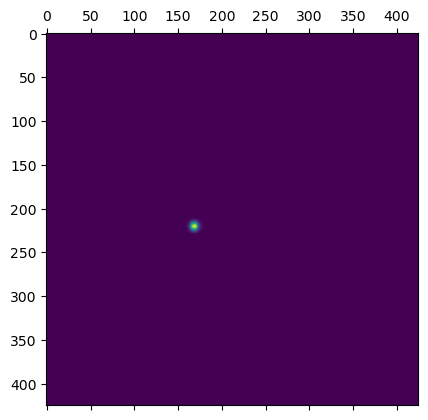

In [27]:
plt.matshow(vals)

## Compute for all voxels and create a matrix K 
Shape: `(voxels x (pixels * pixels))` 

In [28]:
def generate_voxel_maps(dataframe):
    
    # voxels_num = dataframe.shape[0] 
    voxels_num = 10
    voxel_map = np.ones([202500,])
    
    ys, xs = np.mgrid[Y_SIZE:0:-1, 0:X_SIZE]
    ys -= Y_SIZE // 2
    xs -= X_SIZE // 2

    x1d = xs.ravel()
    y1d = ys.ravel()

    for voxel_idx in range(0,voxels_num):
        
        sigma = dataframe["v1_sigma_px"][voxel_idx]
        mu = [dataframe["y_coord"][voxel_idx],dataframe["x_coord"][voxel_idx]]
        
        print(f"Voxel {voxel_idx}, sigma = {sigma}, mu = {mu}")
        # print(f"Voxel {voxel_idx}")
        
        if sigma !=0:
            sigma = np.eye(2) * sigma**2
            mvn = stats.multivariate_normal(mu, sigma)
            
            vals1d = mvn.pdf(np.vstack((y1d, x1d)).T)# 160000 x 1 
            vals = vals1d.reshape(X_SIZE, Y_SIZE)
            
        elif sigma == 0:
            # Create a matrix with where everything is 0 except at the pixels of x,y , where it's 1
            # So it will sum to 1
            
            sigma = np.eye(2) * sigma**2
            vals = np.zeros((X_SIZE,Y_SIZE))
            vals[math.ceil(mu[1]),math.ceil(mu[0])] = 1
            vals1d = vals.reshape(-1)
        
        voxel_map = np.vstack((voxel_map,vals1d))
        
    return voxel_map

In [ ]:
voxel_map = generate_voxel_maps(prf_v1_subj1)

In [ ]:
for i in range(1,voxel_map.shape[0]):
    vals = voxel_map[i].reshape(X_SIZE, Y_SIZE)
    # print(i)
    plt.title(f'Voxel {i}, x = {prf_v1_subj1["x_coord"][i]}, y = {prf_v1_subj1["y_coord"][i]} , angle = {prf_v1_subj1["v1_angle_data"][i]} ')
    plt.matshow(vals)

# Einstein summation for faster processing for mutliple voxels

In [47]:
prf_v1_subj1_valid= prf_v1_subj1_non_zero.copy()

In [48]:
prf_v1_subj1_valid = prf_v1_subj1_valid[prf_v1_subj1_valid['x_coord'].between(-200,200, inclusive= False) & prf_v1_subj1_valid['y_coord'].between(-200,200, inclusive= False) ]

/tmp/ipykernel_42391/1959617130.py:1: FutureWarning: Boolean inputs to the `inclusive` argument are deprecated in favour of `both` or `neither`.
  prf_v1_subj1_valid = prf_v1_subj1_valid[prf_v1_subj1_valid['x_coord'].between(-200,200, inclusive= False) & prf_v1_subj1_valid['y_coord'].between(-200,200, inclusive= False) ]


In [49]:
prf_v1_subj1_valid

,v1_angle_data,v1_ecc_data,v1_sigma_data,v1_ecc_px,v1_sigma_px,x_coord,y_coord
0,179.639786,0.166852,0.003727,14.182429,0.316797,-14.182148,0.089163
1,15.860787,0.690822,0.110961,58.719901,9.431697,56.484351,16.048205
2,163.424911,0.257483,0.022927,21.886015,1.948820,-20.976579,6.243460
3,155.249649,0.013332,0.003601,1.133192,0.306052,-1.029098,0.474428
5,173.044830,0.078608,0.111416,6.681655,9.470335,-6.632486,0.809100
...,...,...,...,...,...,...,...
7876,351.666504,0.458997,0.030384,39.014710,2.582598,38.602763,-5.654584
7879,12.935500,2.371962,0.043102,201.616776,3.663687,196.500283,45.132728
7883,2.510942,0.042029,0.003745,3.572496,0.318334,3.569066,0.156512
7884,105.356026,0.050834,0.213105,4.320889,18.113886,-1.144241,4.166629


In [50]:
np.save(DATA_PATH+"/v1_valid_indices_subj1.npy",prf_v1_subj1_valid.index)

In [51]:
prf_v1_subj1_non_zero

,v1_angle_data,v1_ecc_data,v1_sigma_data,v1_ecc_px,v1_sigma_px,x_coord,y_coord
0,179.639786,0.166852,0.003727,14.182429,0.316797,-14.182148,0.089163
1,15.860787,0.690822,0.110961,58.719901,9.431697,56.484351,16.048205
2,163.424911,0.257483,0.022927,21.886015,1.948820,-20.976579,6.243460
3,155.249649,0.013332,0.003601,1.133192,0.306052,-1.029098,0.474428
4,157.556778,4.178980,0.003570,355.213289,0.303448,-328.308832,135.608966
...,...,...,...,...,...,...,...
7882,247.916855,4.322491,0.016936,367.411749,1.439564,-138.129067,-340.458154
7883,2.510942,0.042029,0.003745,3.572496,0.318334,3.569066,0.156512
7884,105.356026,0.050834,0.213105,4.320889,18.113886,-1.144241,4.166629
7885,15.703278,6.140235,0.033220,521.919971,0.033220,502.439968,141.260519


In [52]:
# ONLY FOR V1 - Subj1 
voxels_num = prf_v1_subj1_valid.shape[0] # 4165 voxels 

# Create two lists 
sigma = prf_v1_subj1_valid["v1_sigma_px"]
sigma = sigma **2 

In [53]:
prf_v1_subj1_valid.min(axis=0)

v1_angle_data      0.000328
v1_ecc_data        0.003115
v1_sigma_data      0.000391
v1_ecc_px          0.264734
v1_sigma_px        0.033220
x_coord         -199.129769
y_coord         -199.972532
dtype: float64

In [54]:
# invert all covariance matrices in one go using the fact that the inverse of a
# diagonal matrix is a diagonal matrix with diagonal elements replaced by the
# reciprocals of the original diagonal matrix
sigma_arr = sigma.to_numpy().reshape((1,1,-1)) # (1, 1, 7887)
sigmas_inv = np.stack([np.eye(2)] * voxels_num, 2) / sigma_arr # (2, 2, 7887)

mu_arr = np.array( [prf_v1_subj1_valid["y_coord"].to_numpy() ,prf_v1_subj1_valid["x_coord"].to_numpy()]) # (2, 7887)

In [55]:
# turn all points in the image into an array of x, y coordinate pairs and
# and expand with the number of voxels
# Longer execution time 
X = np.stack([coord_pairs] * voxels_num, 2)  # (160000, 2, 7887)

In [56]:
X.shape

(180625, 2, 4165)

In [57]:
# subtract the pRF means from each of these coordinate pairs so that
# coordinates are relative to pRF centers
delta_X = X - mu_arr

# delta_X = np.ceil(delta_X) 
# delta_X = delta_X.astype('int32')

In [46]:
# calculate first part of exponent in multivariate PDF for all voxels at all
# image locations, i.e.:
#
# (x - mu)T * S^{-1} ...
#

F1 = np.einsum('ij...,jk...', delta_X, sigmas_inv)

In [47]:
# proceed with the second part of the calculation in the exponent, i.e.:
#
# ... F1 * (x - mu)
F2 = np.einsum('...i,...i', F1, delta_X.transpose(2, 0, 1))

In [48]:
# divide exponent by -2 and compute power
pdfs = np.exp(-.5 * F2)

In [49]:
(pdfs.sum(axis=1) == 0).sum()

0

In [50]:
# instead of calculating the factor outside the power, simply rescale PDFs so
# that they integrate to 1.
pdfs = pdfs / np.tile(pdfs.sum(axis=1), (X_SIZE * Y_SIZE, 1)).T # (7887, 160000)

In [51]:
pdfs.shape

(4165, 180625)

In [52]:
prf_v1_subj1_non_zero.iloc[4]

v1_angle_data    157.556778
v1_ecc_data        4.178980
v1_sigma_data      0.003570
v1_ecc_px        355.213289
v1_sigma_px        0.303448
x_coord         -328.308832
y_coord          135.608966
Name: 4, dtype: float64

In [129]:
pdfs_compr = np.float32(pdfs)

In [87]:
np.savez_compressed(DATA_PATH+"/K_mat_subj1_v1.npy",pdfs)

In [ ]:
# np.save(DATA_PATH+"/K_mat_subj1_v1_compressed.npy",pdfs_compr)

## Functionalize for all ROIs 

In [60]:
def get_no_of_nans(arr):
    return np.count_nonzero(np.isnan(arr))

In [29]:
def gen_prf_maps_einstein(df, roi):
    
    # Replace zero sigmas with next highest value
    min_val_nonzero = df[f'{roi}_sigma_px'][df[f'{roi}_sigma_px']!=0].min(axis=0)
    
    df_non_zero = df.copy()
    
    df_non_zero[f'{roi}_sigma_data'].replace(to_replace = 0, value = min_val_nonzero, inplace = True)
    df_non_zero[f'{roi}_sigma_px'].replace(to_replace = 0, value = min_val_nonzero, inplace = True)

    
    df_valid = df_non_zero[df_non_zero['x_coord'].between(-200,200, inclusive= 'both') & 
                           df_non_zero['y_coord'].between(-200,200, inclusive= 'both') ]
    
    # save valid indices of the "good" voxels to disk 
    np.save(DATA_PATH+f"/{roi}_valid_indices_subj1.npy",df_valid.index)
    
    # Einstein summation begin: 
    voxels_num = df_valid.shape[0] # 4165 voxels 

    # Create two lists 
    sigma = df_valid[f"{roi}_sigma_px"]
    sigma = sigma **2 
    
    
    
    # invert all covariance matrices in one go using the fact that the inverse of a
    # diagonal matrix is a diagonal matrix with diagonal elements replaced by the
    # reciprocals of the original diagonal matrix
    sigma_arr = sigma.to_numpy().reshape((1,1,-1)) # (1, 1, 4165)    
    
    sigmas_inv = np.stack([np.eye(2)] * voxels_num, 2) / sigma_arr # (2, 2, 4165)
    
    mu_arr = np.array( [df_valid["y_coord"].to_numpy() ,df_valid["x_coord"].to_numpy()]) # (2, 4165)
   
    
    # turn all points in the image into an array of x, y coordinate pairs and
    # and expand with the number of voxels
    X = np.stack([coord_pairs] * voxels_num, 2)  # (180625, 2, 4165)
    
    
    # subtract the pRF means from each of these coordinate pairs so that
    # coordinates are relative to pRF cente
    delta_X = X - mu_arr
    
    
    # calculate first part of exponent in multivariate PDF for all voxels at all iamges
    F1 = np.einsum('ij...,jk...', delta_X, sigmas_inv)
    
    # proceed with the second part of the calculation in the exponent, i.e.:
    F2 = np.einsum('...i,...i', F1, delta_X.transpose(2, 0, 1))
    
    
    # divide exponent by -2 and compute power
    pdfs = np.exp(-.5 * F2) # 4165 x 180625 i.e. (voxels x (img_size*img_size))
    
    print(f"No of Voxels with PDF summing to zero (will be removed): {(pdfs.sum(axis=1) == 0).sum()}") # Take sum across each voxel 
     
    # Remove the voxels whose PDFs sum to zero 
    sum_across_voxels = pdfs.sum(axis=1)
    non_zero_sum_mask = (sum_across_voxels != 0)
    pdfs = pdfs[non_zero_sum_mask]
    
    
    
    # instead of calculating the factor outside the power, simply rescale PDFs so that they integrate to 1.
    pdfs = pdfs / np.tile(pdfs.sum(axis=1), (X_SIZE * Y_SIZE, 1)).T #(4165, 180625)
    print(f"PDF matrix shape: {pdfs.shape}")
    
    # print(f"No of Voxels with PDF summing to zero: {(pdfs.sum(axis=1) == 0).sum()}")
    return pdfs, non_zero_sum_mask

In [97]:
mask, pdfs_ffa2 = gen_prf_maps_einstein(all_roi_df_dict_subj1['prf_df_ffa2'], 'ffa2')

No of Voxels with PDF summing to zero (will be removed): 28
(1344,)
PDF matrix shape: (1316, 180625)


In [86]:
np.count_nonzero(np.isnan(pdfs_ffa2))

0

In [131]:
# pdfs_v1_prf = gen_prf_maps_einstein(prf_df_v1_roi, 'v1')
# np.savez_compressed(DATA_PATH+"/K_mat_subj1_v1.npy",pdfs_v1_prf)

/tmp/ipykernel_29920/47425543.py:12: FutureWarning: Boolean inputs to the `inclusive` argument are deprecated in favour of `both` or `neither`.
  df_valid = df_non_zero[df_non_zero['x_coord'].between(-200,200, inclusive= False) &
/tmp/ipykernel_29920/47425543.py:13: FutureWarning: Boolean inputs to the `inclusive` argument are deprecated in favour of `both` or `neither`.
  df_non_zero['y_coord'].between(-200,200, inclusive= False) ]


Sum of PDF: 0
PDF matrix shape: (4165, 180625)


In [ ]:
# pdfs_v2_prf = gen_prf_maps_einstein(prf_df_v2_roi, 'v2')
# np.savez_compressed(DATA_PATH+"/K_mat_subj1_v2.npy",pdfs_v2_prf)
# # PDF matrix shape: (4388, 180625)

/tmp/ipykernel_29920/47425543.py:12: FutureWarning: Boolean inputs to the `inclusive` argument are deprecated in favour of `both` or `neither`.
  df_valid = df_non_zero[df_non_zero['x_coord'].between(-200,200, inclusive= False) &
/tmp/ipykernel_29920/47425543.py:13: FutureWarning: Boolean inputs to the `inclusive` argument are deprecated in favour of `both` or `neither`.
  df_non_zero['y_coord'].between(-200,200, inclusive= False) ]


Sum of PDF: 0
PDF matrix shape: (4388, 180625)


In [120]:
# pdfs_v3_prf = gen_prf_maps_einstein(prf_df_v3_roi, 'v3')
# np.savez_compressed(DATA_PATH+"/K_mat_subj1_v3.npy",pdfs_v3_prf)
# # PDF matrix shape: (3311, 180625)

/tmp/ipykernel_29920/47425543.py:12: FutureWarning: Boolean inputs to the `inclusive` argument are deprecated in favour of `both` or `neither`.
  df_valid = df_non_zero[df_non_zero['x_coord'].between(-200,200, inclusive= False) &
/tmp/ipykernel_29920/47425543.py:13: FutureWarning: Boolean inputs to the `inclusive` argument are deprecated in favour of `both` or `neither`.
  df_non_zero['y_coord'].between(-200,200, inclusive= False) ]


Sum of PDF: 0
PDF matrix shape: (3311, 180625)


In [121]:
# pdfs_v4_prf = gen_prf_maps_einstein(prf_df_v4_roi, 'v4')
# np.savez_compressed(DATA_PATH+"/K_mat_subj1_v4.npy",pdfs_v4_prf)
# # PDF matrix shape: (2615, 180625)

/tmp/ipykernel_29920/47425543.py:12: FutureWarning: Boolean inputs to the `inclusive` argument are deprecated in favour of `both` or `neither`.
  df_valid = df_non_zero[df_non_zero['x_coord'].between(-200,200, inclusive= False) &
/tmp/ipykernel_29920/47425543.py:13: FutureWarning: Boolean inputs to the `inclusive` argument are deprecated in favour of `both` or `neither`.
  df_non_zero['y_coord'].between(-200,200, inclusive= False) ]


Sum of PDF: 0
PDF matrix shape: (2615, 180625)


# Visualisations

## Summing the probability densities across voxels

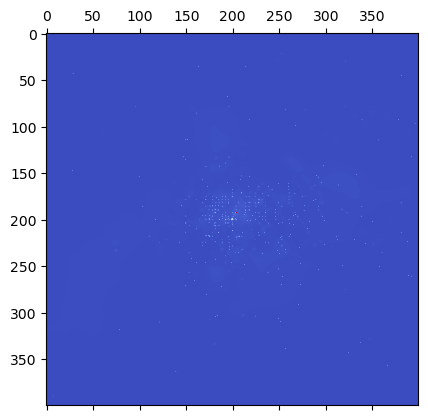

In [98]:
plt.matshow(pdfs.reshape(pdfs.shape[0], 400, 400).sum(axis=0), cmap='coolwarm')

## Scatterplot of the `mu(x,y)` and the `sigmas`


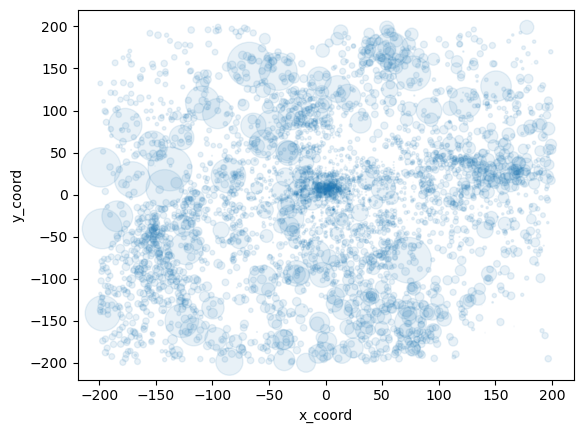

In [111]:
ax1 = prf_v1_subj1_valid.plot.scatter(x='x_coord',y='y_coord', s='v1_sigma_px', alpha = 0.1)

## Raw PDF for each voxel 

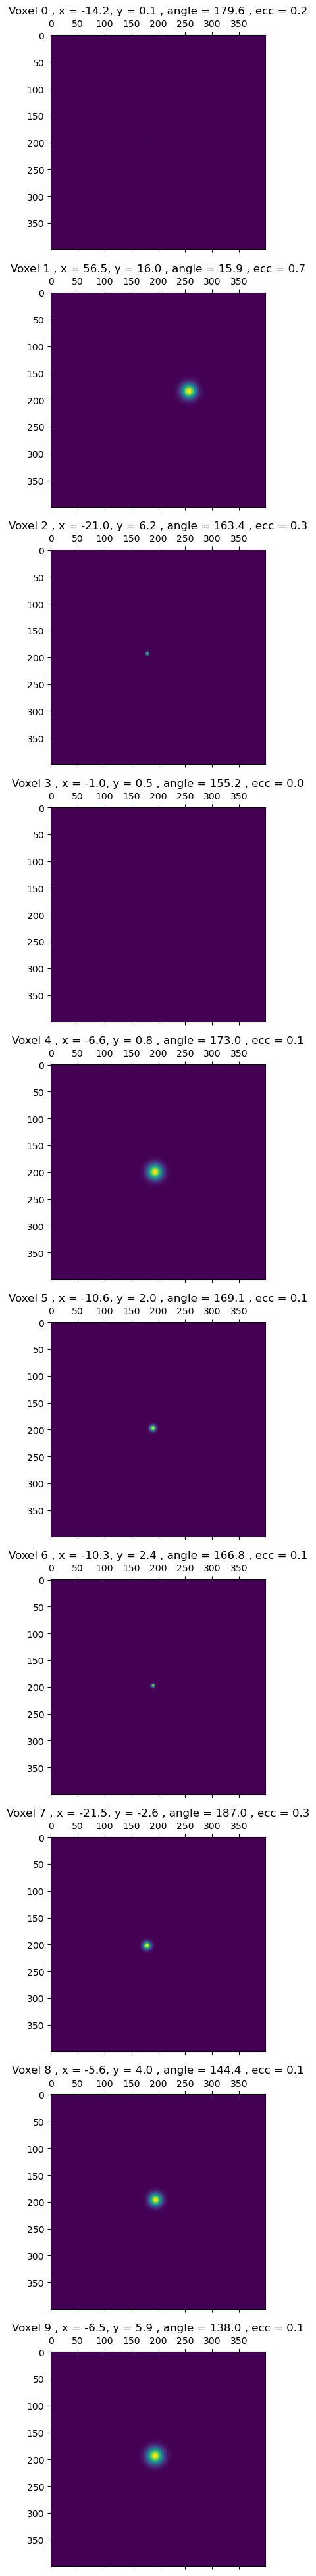

In [101]:
fig, axs = plt.subplots(10,figsize=(30, 50))
for i in range(0,10):
    axs[i].set_title(f"Voxel {i} , x = {prf_v1_subj1_valid.iloc[i]['x_coord']:.1f}, y = {prf_v1_subj1_valid.iloc[i]['y_coord']:.1f} , angle = {prf_v1_subj1_valid.iloc[i]['v1_angle_data']:.1f} , ecc = {prf_v1_subj1_valid.iloc[i]['v1_ecc_data']:.1f}")
    axs[i].matshow(pdfs[i].reshape(X_SIZE, Y_SIZE))

# Extend above for all of the ROIs 

Todo: remove and clean previous section

In [30]:
prf_df_subj1_all_roi = pd.read_pickle(DATA_PATH+"/prf_df_subj1_all_rois.pkl")
prf_df_subj2_all_roi = pd.read_pickle(DATA_PATH+"/prf_df_subj2_all_rois.pkl")
prf_df_subj3_all_roi = pd.read_pickle(DATA_PATH+"/prf_df_subj3_all_rois.pkl")
prf_df_subj4_all_roi = pd.read_pickle(DATA_PATH+"/prf_df_subj4_all_rois.pkl")

In [31]:
prf_df_subj1_all_roi.head()

,v1_angle_data,v1_ecc_data,v1_sigma_data,v1_r2_data,v2_angle_data,v2_ecc_data,v2_sigma_data,v2_r2_data,v3_angle_data,v3_ecc_data,...,ips5_sigma_data,ips5_r2_data,spl1_angle_data,spl1_ecc_data,spl1_sigma_data,spl1_r2_data,fef_angle_data,fef_ecc_data,fef_sigma_data,fef_r2_data
0,179.639786,0.166852,0.003727,3.616053,33.354454,0.371874,0.076283,50.161469,140.120987,0.134440,...,0.001007,0.952959,303.631653,0.004879,0.005845,6.592977,15.519954,1.874922,0.000000,8.283156
1,15.860787,0.690822,0.110961,11.148829,28.464493,0.456244,0.062072,46.987682,165.033951,0.101685,...,0.044667,10.231751,260.028168,2.119535,0.000000,-34.260132,42.804577,0.171886,0.063137,3.490609
2,163.424911,0.257483,0.022927,2.095020,31.106401,0.452306,0.090546,38.588326,218.715668,0.039451,...,0.002873,2.159804,206.204697,0.169597,0.049572,1.431602,21.195547,5.540983,0.169521,0.115997
3,155.249649,0.013332,0.003601,4.394990,14.747509,0.457834,0.034184,57.201149,124.930138,0.175418,...,0.003961,8.219748,204.563492,0.093858,0.050503,0.238627,48.358818,0.148282,0.031682,4.514545
4,157.556778,4.178980,0.003570,5.346769,29.082649,0.395024,0.072307,55.691982,96.409996,0.155090,...,0.004131,2.941710,248.007629,0.020016,0.003099,2.057016,29.079445,2.275700,0.011382,0.861126


In [59]:
def generate_prf_all_roi_df(roi): # RENAME THE FUNCTION  
    '''
    Create a seperate dataframe for each of the ROI (unfortunate, but no other option due to sizing issues) 
    '''
    
    prf_df_roi = prf_df_subj1_all_roi[[f'{roi}_angle_data',f'{roi}_ecc_data',f'{roi}_sigma_data']].dropna()
    prf_df_roi[f"{roi}_ecc_px"] = prf_df_roi[f"{roi}_ecc_data"]*714/8.4
    prf_df_roi[f"{roi}_sigma_px"] =prf_df_roi[f"{roi}_sigma_data"]*714/8.4
    
    prf_df_roi["x_coord"] = prf_df_roi[f"{roi}_ecc_px"]*np.cos(np.deg2rad(prf_df_roi[f"{roi}_angle_data"]))
    prf_df_roi["y_coord"] = prf_df_roi[f"{roi}_ecc_px"]*np.sin(np.deg2rad(prf_df_roi[f"{roi}_angle_data"]))
    
    return prf_df_roi

In [21]:
prf_df_ofa_roi = generate_prf_all_roi_df("ofa")
prf_df_ofa_roi.head()

,ofa_angle_data,ofa_ecc_data,ofa_sigma_data,ofa_ecc_px,ofa_sigma_px,x_coord,y_coord
0,314.345642,8.297270,0.594952,705.267935,50.570909,492.971840,-504.362593
1,310.350037,7.014858,0.767259,596.262951,65.217000,386.053771,-454.413900
2,324.084747,2.973340,0.776627,252.733883,66.013260,204.685510,-148.250657
3,318.419250,6.347569,0.718231,539.543364,61.049662,403.589830,-358.081403
4,325.886780,2.793029,0.535074,237.407430,45.481325,196.556960,-133.145219


In [38]:
# # New method that doesnt take a seperate ROI list 
# # all_roi_df_dict = {} 

# # take uniuqe ROI values
# rois_from_df = set() 

# # Take pandas column names as input in the form of X_Y_data and extract X from the column name, and add it to a seperate set


# for col in prf_df_subj1_all_roi.columns:
#     roi_value = col.split('_')[0] # Split the column name
#     rois_from_df.add(roi_value) 

In [20]:
# rois = ["v1","v2","v3","v4",
#         "ofa","ffa1", "ffa2", "atl",
#         "eba","fba1", "fba2",
#         "opa", "ppa", "rsc",
#         "owfa", "vwfa_1", "vwfa_2", "mfs_words", "mtl_words"]

# all_roi_df_dict = {}

# for roi in rois: 
#     df_name = f"prf_df_{roi}_roi"
#     df = generate_prf_all_roi_df(roi)
    
#     all_roi_df_dict[df_name] = df 
    

In [33]:
def get_roi_from_df(dataframe):
    rois_from_df = set() 

    for col in dataframe.columns:
        parts = col.split('_')

        if len(parts) >=3 and parts[-2] != 'data':
            roi_value = '_'.join(parts[:-2]) # handle the case when it's mtl_words_sigma_data --> get mtl_words instead of just mtl 
        else:
            roi_value = parts[0]
        rois_from_df.add(roi_value) 
    
    return rois_from_df

print(get_roi_from_df(prf_df_subj1_all_roi)) 

{'owfa', 'v3', 'vo2', 'v2', 'rsc', 'ofa', 'phc2', 'spl1', 'vwfa_1', 'fef', 'ips3', 'v3a', 'ffa2', 'ips1', 'eba', 'lo2', 'v4', 'ffa1', 'v3b', 'vo1', 'ips0', 'fba1', 'ips5', 'mfs_words', 'atl', 'vwfa_2', 'hmt', 'ips2', 'ppa', 'mst', 'ips4', 'opa', 'phc1', 'mtl_words', 'lo1', 'fba2', 'v1'}


In [34]:
def create_sep_roi_df_dict(subject):
    
    prf_df_subj_all_roi = pd.read_pickle(DATA_PATH+f"/prf_df_subj{subject}_all_rois.pkl")

    all_roi_df_dict = {} 

    # Get ROIs for the specific subject 
    rois_from_df = get_roi_from_df(prf_df_subj_all_roi)

    # Now rois_from_df is populated with the valid ROIs of the corresponding subject (no empty ROIs) 
    
    for roi in rois_from_df:
        df_name = f"prf_df_{roi}"
        df = generate_prf_all_roi_df(roi)
        all_roi_df_dict[df_name] = df 
        
    return all_roi_df_dict

In [35]:
all_roi_df_dict_subj1 = create_sep_roi_df_dict(subject = 1) 
all_roi_df_dict_subj1 = create_sep_roi_df_dict(subject = 2) 
all_roi_df_dict_subj1 = create_sep_roi_df_dict(subject = 3) 
all_roi_df_dict_subj1 = create_sep_roi_df_dict(subject = 4) 


In [26]:
all_roi_df_dict_subj1['prf_df_mtl_words']

,mtl_words_angle_data,mtl_words_ecc_data,mtl_words_sigma_data,mtl_words_ecc_px,mtl_words_sigma_px,x_coord,y_coord
0,24.761469,14.598044,1.401397,1240.833774,119.118744,1126.750713,519.712694
1,43.633198,6.042749,0.234545,513.633699,19.936319,371.753776,354.427295
2,16.780346,6.426172,0.149319,546.224601,12.692116,522.965586,157.696895
3,249.170761,4.343145,0.028019,369.167356,2.381634,-131.269995,-345.040180
4,264.556305,3.122056,0.004043,265.374801,0.343648,-25.175450,-264.177936
...,...,...,...,...,...,...,...
670,202.578903,8.430469,0.489712,716.589828,41.625517,-661.664403,-275.138507
671,226.751190,6.173764,0.216419,524.769959,18.395586,-359.555510,-382.234673
672,139.274475,0.386941,0.004104,32.889979,0.348800,-24.925465,21.458609
673,35.356281,1.332110,0.087376,113.229324,7.426947,92.346391,65.521171


In [27]:
all_roi_df_dict_subj1['prf_df_ffa2']

,ffa2_angle_data,ffa2_ecc_data,ffa2_sigma_data,ffa2_ecc_px,ffa2_sigma_px,x_coord,y_coord
0,95.105301,0.171067,0.038238,14.540684,3.250265,-1.293924,14.482998
1,103.817596,0.132276,0.035180,11.243423,2.990293,-2.685286,10.918049
2,133.852417,0.166054,0.041585,14.114607,3.534687,-9.778645,10.178420
3,169.548752,0.006137,0.004994,0.521632,0.424481,-0.512978,0.094624
4,46.333279,0.177583,0.004326,15.094573,0.367707,10.422235,10.918936
...,...,...,...,...,...,...,...
1818,289.822662,8.221016,0.471863,698.786354,40.108365,236.965470,-657.380966
1819,22.550190,0.252847,0.397127,21.491956,33.755762,19.848766,8.242006
1820,91.591888,0.139518,0.039164,11.859031,3.328918,-0.329445,11.854454
1821,15.207580,11.080244,0.797292,941.820745,67.769819,908.839879,247.055440


In [36]:
def save_K_matrix_subjectwise(subject):
    
    prf_df_subj_all_roi = pd.read_pickle(DATA_PATH+f"/prf_df_subj{subject}_all_rois.pkl")
    all_roi_df_dict_subj = create_sep_roi_df_dict(subject = subject)
    rois_from_df = get_roi_from_df(prf_df_subj_all_roi)
    
    print(f"Generating for subject: {subject} \n")
    
    for roi_df, roi in zip(tqdm(all_roi_df_dict_subj), rois_from_df):

        k_mat_name = f"K_mat_subj{subject}_{roi}.npy"
        print(f"Generating for {roi}")
        pdfs_roi, non_zero_mask_roi = gen_prf_maps_einstein(all_roi_df_dict_subj[roi_df], roi) 
        
        # Save the non_zero voxels' mask to disk 
        np.save(DATA_PATH+f"/non_zero_voxel_mask_subj{subject}_{roi}.npy",non_zero_mask_roi)
        
        np.savez_compressed(DATA_PATH+"/"+k_mat_name, pdfs_roi)


In [107]:
save_K_matrix_subjectwise(subject = 1)

Generating for subject: 1 



  0%|          | 0/37 [00:00<?, ?it/s]

Generating for mtl_words
No of Voxels with PDF summing to zero (will be removed): 0
PDF matrix shape: (219, 180625)


  3%|▎         | 1/37 [00:08<05:13,  8.72s/it]

Generating for vwfa_1
No of Voxels with PDF summing to zero (will be removed): 243
PDF matrix shape: (3370, 180625)


  5%|▌         | 2/37 [03:39<1:14:21, 127.47s/it]

Generating for vo1
No of Voxels with PDF summing to zero (will be removed): 0
PDF matrix shape: (381, 180625)


  8%|▊         | 3/37 [04:03<45:29, 80.28s/it]   

Generating for ffa2
No of Voxels with PDF summing to zero (will be removed): 28
PDF matrix shape: (1316, 180625)


 11%|█         | 4/37 [05:08<40:54, 74.37s/it]

Generating for fef
No of Voxels with PDF summing to zero (will be removed): 0
PDF matrix shape: (283, 180625)


 14%|█▎        | 5/37 [05:21<27:54, 52.32s/it]

Generating for atl
No of Voxels with PDF summing to zero (will be removed): 0
PDF matrix shape: (404, 180625)


 16%|█▌        | 6/37 [05:38<20:41, 40.04s/it]

Generating for ips5
No of Voxels with PDF summing to zero (will be removed): 0
PDF matrix shape: (53, 180625)


 19%|█▉        | 7/37 [05:41<14:02, 28.08s/it]

Generating for ips0
No of Voxels with PDF summing to zero (will be removed): 0
PDF matrix shape: (2133, 180625)


 22%|██▏       | 8/37 [07:46<28:30, 59.00s/it]

Generating for ips3
No of Voxels with PDF summing to zero (will be removed): 0
PDF matrix shape: (2185, 180625)


 24%|██▍       | 9/37 [09:44<36:02, 77.23s/it]

Generating for eba
No of Voxels with PDF summing to zero (will be removed): 900
PDF matrix shape: (7763, 180625)


 27%|██▋       | 10/37 [19:05<1:41:57, 226.58s/it]

Generating for phc1
No of Voxels with PDF summing to zero (will be removed): 0
PDF matrix shape: (640, 180625)


 30%|██▉       | 11/37 [19:45<1:13:29, 169.60s/it]

Generating for mst
No of Voxels with PDF summing to zero (will be removed): 0
PDF matrix shape: (50, 180625)


 32%|███▏      | 12/37 [19:48<49:36, 119.05s/it]  

Generating for ips2
No of Voxels with PDF summing to zero (will be removed): 196
PDF matrix shape: (1750, 180625)


 35%|███▌      | 13/37 [21:20<44:17, 110.73s/it]

Generating for v2
No of Voxels with PDF summing to zero (will be removed): 0
PDF matrix shape: (4388, 180625)


 38%|███▊      | 14/37 [26:29<1:05:22, 170.55s/it]

Generating for spl1
No of Voxels with PDF summing to zero (will be removed): 0
PDF matrix shape: (713, 180625)


 41%|████      | 15/37 [27:02<47:23, 129.25s/it]  

Generating for opa
No of Voxels with PDF summing to zero (will be removed): 305
PDF matrix shape: (5655, 180625)


 43%|████▎     | 16/37 [33:34<1:12:49, 208.08s/it]

Generating for rsc
No of Voxels with PDF summing to zero (will be removed): 178
PDF matrix shape: (1260, 180625)


 46%|████▌     | 17/37 [34:39<55:04, 165.23s/it]  

Generating for vwfa_2
No of Voxels with PDF summing to zero (will be removed): 22
PDF matrix shape: (2224, 180625)


 49%|████▊     | 18/37 [36:37<47:51, 151.15s/it]

Generating for ips4
No of Voxels with PDF summing to zero (will be removed): 17
PDF matrix shape: (255, 180625)


 51%|█████▏    | 19/37 [36:54<33:14, 110.82s/it]

Generating for ips1
No of Voxels with PDF summing to zero (will be removed): 144
PDF matrix shape: (1943, 180625)


 54%|█████▍    | 20/37 [38:45<31:21, 110.66s/it]

Generating for fba1
No of Voxels with PDF summing to zero (will be removed): 0
PDF matrix shape: (1378, 180625)


 57%|█████▋    | 21/37 [40:06<27:10, 101.89s/it]

Generating for owfa
No of Voxels with PDF summing to zero (will be removed): 0
PDF matrix shape: (2521, 180625)


 59%|█████▉    | 22/37 [42:59<30:48, 123.26s/it]

Generating for v3a
No of Voxels with PDF summing to zero (will be removed): 19
PDF matrix shape: (1001, 180625)


 62%|██████▏   | 23/37 [44:08<24:55, 106.80s/it]

Generating for v3b
No of Voxels with PDF summing to zero (will be removed): 0
PDF matrix shape: (970, 180625)


 65%|██████▍   | 24/37 [45:10<20:15, 93.53s/it] 

Generating for mfs_words
No of Voxels with PDF summing to zero (will be removed): 0
PDF matrix shape: (570, 180625)


 68%|██████▊   | 25/37 [45:36<14:37, 73.09s/it]

Generating for v3
No of Voxels with PDF summing to zero (will be removed): 0
PDF matrix shape: (3311, 180625)


 70%|███████   | 26/37 [49:07<21:00, 114.60s/it]

Generating for fba2
No of Voxels with PDF summing to zero (will be removed): 25
PDF matrix shape: (1910, 180625)


 73%|███████▎  | 27/37 [50:45<18:16, 109.63s/it]

Generating for hmt
No of Voxels with PDF summing to zero (will be removed): 32
PDF matrix shape: (524, 180625)


 76%|███████▌  | 28/37 [51:20<13:04, 87.14s/it] 

Generating for v4
No of Voxels with PDF summing to zero (will be removed): 0
PDF matrix shape: (2615, 180625)


 78%|███████▊  | 29/37 [54:09<14:53, 111.69s/it]

Generating for lo1
No of Voxels with PDF summing to zero (will be removed): 0
PDF matrix shape: (1569, 180625)


 81%|████████  | 30/37 [55:51<12:43, 109.01s/it]

Generating for phc2
No of Voxels with PDF summing to zero (will be removed): 0
PDF matrix shape: (629, 180625)


 84%|████████▍ | 31/37 [56:22<08:33, 85.54s/it] 

Generating for ppa
No of Voxels with PDF summing to zero (will be removed): 191
PDF matrix shape: (2265, 180625)


 86%|████████▋ | 32/37 [58:20<07:55, 95.09s/it]

Generating for v1
No of Voxels with PDF summing to zero (will be removed): 0
PDF matrix shape: (4165, 180625)


 89%|████████▉ | 33/37 [1:02:40<09:38, 144.70s/it]

Generating for lo2
No of Voxels with PDF summing to zero (will be removed): 0
PDF matrix shape: (891, 180625)


 92%|█████████▏| 34/37 [1:03:37<05:55, 118.47s/it]

Generating for ffa1
No of Voxels with PDF summing to zero (will be removed): 0
PDF matrix shape: (1966, 180625)


 95%|█████████▍| 35/37 [1:05:33<03:55, 117.64s/it]

Generating for ofa
No of Voxels with PDF summing to zero (will be removed): 0
PDF matrix shape: (1889, 180625)


 97%|█████████▋| 36/37 [1:07:31<01:57, 117.65s/it]

Generating for vo2
No of Voxels with PDF summing to zero (will be removed): 0
PDF matrix shape: (1201, 180625)


100%|██████████| 37/37 [1:08:39<00:00, 111.33s/it]


In [ ]:






def gen_prf_maps_einstein(df, roi):
    
    # Replace zero sigmas with next highest value
    min_val_nonzero = df[f'{roi}_sigma_px'][df[f'{roi}_sigma_px']!=0].min(axis=0)
    
    df_non_zero = df.copy()
    
    df_non_zero[f'{roi}_sigma_data'].replace(to_replace = 0, value = min_val_nonzero, inplace = True)
    df_non_zero[f'{roi}_sigma_px'].replace(to_replace = 0, value = min_val_nonzero, inplace = True)

    
    df_valid = df_non_zero[df_non_zero['x_coord'].between(-200,200, inclusive= 'both') & 
                           df_non_zero['y_coord'].between(-200,200, inclusive= 'both') ]
    
    # save valid indices of the "good" voxels to disk 
    np.save(DATA_PATH+f"/{roi}_valid_indices_subj1.npy",df_valid.index)
    

In [62]:
# Save valid indices 
def save_valid_indices(subject):
    
    prf_df_subj_all_roi = pd.read_pickle(DATA_PATH+f"/prf_df_subj{subject}_all_rois.pkl")
    all_roi_df_dict_subj = create_sep_roi_df_dict(subject = subject)
    rois_from_df = get_roi_from_df(prf_df_subj_all_roi)
    
    print(f"Generating for subject: {subject} \n")
    
    for roi_df, roi in zip(tqdm(all_roi_df_dict_subj), rois_from_df):
        print(f"Generating for {roi}")
        
        df = all_roi_df_dict_subj[roi_df]
        
        min_val_nonzero = df[f'{roi}_sigma_px'][df[f'{roi}_sigma_px']!=0].min(axis=0)
    
        df_non_zero = df.copy()

        df_non_zero[f'{roi}_sigma_data'].replace(to_replace = 0, value = min_val_nonzero, inplace = True)
        df_non_zero[f'{roi}_sigma_px'].replace(to_replace = 0, value = min_val_nonzero, inplace = True)


        df_valid = df_non_zero[df_non_zero['x_coord'].between(-200,200, inclusive= 'both') & 
                               df_non_zero['y_coord'].between(-200,200, inclusive= 'both') ]

        # save valid indices of the "good" voxels to disk 
        np.save(DATA_PATH+f"/{roi}_valid_indices_subj{subject}.npy",df_valid.index)
        print(f"Saved {roi} to disk")
       


In [63]:
save_valid_indices(subject = 1) 

Generating for subject: 1 



 51%|█████▏    | 19/37 [00:00<00:00, 186.03it/s]

Generating for owfa
Saved owfa to disk
Generating for v3
Saved v3 to disk
Generating for vo2
Saved vo2 to disk
Generating for v2
Saved v2 to disk
Generating for rsc
Saved rsc to disk
Generating for ofa
Saved ofa to disk
Generating for phc2
Saved phc2 to disk
Generating for spl1
Saved spl1 to disk
Generating for vwfa_1
Saved vwfa_1 to disk
Generating for fef
Saved fef to disk
Generating for ips3
Saved ips3 to disk
Generating for v3a
Saved v3a to disk
Generating for ffa2
Saved ffa2 to disk
Generating for ips1
Saved ips1 to disk
Generating for eba
Saved eba to disk
Generating for lo2
Saved lo2 to disk
Generating for v4
Saved v4 to disk
Generating for ffa1
Saved ffa1 to disk
Generating for v3b
Saved v3b to disk
Generating for vo1
Saved vo1 to disk
Generating for ips0
Saved ips0 to disk
Generating for fba1
Saved fba1 to disk
Generating for ips5
Saved ips5 to disk
Generating for mfs_words
Saved mfs_words to disk
Generating for atl
Saved atl to disk
Generating for vwfa_2
Saved vwfa_2 to disk


100%|██████████| 37/37 [00:00<00:00, 173.36it/s]

Saved v1 to disk


In [64]:
save_valid_indices(subject = 2) 

Generating for subject: 2 



100%|██████████| 36/36 [00:00<00:00, 406.04it/s]

Generating for owfa
Saved owfa to disk
Generating for v3
Saved v3 to disk
Generating for vo2
Saved vo2 to disk
Generating for v2
Saved v2 to disk
Generating for rsc
Saved rsc to disk
Generating for ofa
Saved ofa to disk
Generating for phc2
Saved phc2 to disk
Generating for spl1
Saved spl1 to disk
Generating for vwfa_1
Saved vwfa_1 to disk
Generating for fef
Saved fef to disk
Generating for ips3
Saved ips3 to disk
Generating for v3a
Saved v3a to disk
Generating for ffa2
Saved ffa2 to disk
Generating for ips1
Saved ips1 to disk
Generating for eba
Saved eba to disk
Generating for lo2
Saved lo2 to disk
Generating for v4
Saved v4 to disk
Generating for ffa1
Saved ffa1 to disk
Generating for v3b
Saved v3b to disk
Generating for vo1
Saved vo1 to disk
Generating for ips0
Saved ips0 to disk
Generating for ips5
Saved ips5 to disk
Generating for mfs_words
Saved mfs_words to disk
Generating for atl
Saved atl to disk
Generating for vwfa_2
Saved vwfa_2 to disk
Generating for hmt
Saved hmt to disk
Ge

In [65]:
save_valid_indices(subject = 3) 

Generating for subject: 3 



100%|██████████| 36/36 [00:00<00:00, 408.47it/s]

Generating for owfa
Saved owfa to disk
Generating for v3
Saved v3 to disk
Generating for vo2
Saved vo2 to disk
Generating for v2
Saved v2 to disk
Generating for rsc
Saved rsc to disk
Generating for ofa
Saved ofa to disk
Generating for phc2
Saved phc2 to disk
Generating for spl1
Saved spl1 to disk
Generating for vwfa_1
Saved vwfa_1 to disk
Generating for fef
Saved fef to disk
Generating for ips3
Saved ips3 to disk
Generating for v3a
Saved v3a to disk
Generating for ffa2
Saved ffa2 to disk
Generating for ips1
Saved ips1 to disk
Generating for eba
Saved eba to disk
Generating for lo2
Saved lo2 to disk
Generating for v4
Saved v4 to disk
Generating for ffa1
Saved ffa1 to disk
Generating for v3b
Saved v3b to disk
Generating for vo1
Saved vo1 to disk
Generating for ips0
Saved ips0 to disk
Generating for fba1
Saved fba1 to disk
Generating for ips5
Saved ips5 to disk
Generating for mfs_words
Saved mfs_words to disk
Generating for atl
Saved atl to disk
Generating for vwfa_2
Saved vwfa_2 to disk


In [66]:
save_valid_indices(subject = 4) 

Generating for subject: 4 



100%|██████████| 36/36 [00:00<00:00, 364.54it/s]

Generating for owfa
Saved owfa to disk
Generating for v3
Saved v3 to disk
Generating for vo2
Saved vo2 to disk
Generating for v2
Saved v2 to disk
Generating for rsc
Saved rsc to disk
Generating for ofa
Saved ofa to disk
Generating for phc2
Saved phc2 to disk
Generating for spl1
Saved spl1 to disk
Generating for vwfa_1
Saved vwfa_1 to disk
Generating for fef
Saved fef to disk
Generating for ips3
Saved ips3 to disk
Generating for v3a
Saved v3a to disk
Generating for ffa2
Saved ffa2 to disk
Generating for ips1
Saved ips1 to disk
Generating for eba
Saved eba to disk
Generating for lo2
Saved lo2 to disk
Generating for v4
Saved v4 to disk
Generating for ffa1
Saved ffa1 to disk
Generating for v3b
Saved v3b to disk
Generating for vo1
Saved vo1 to disk
Generating for ips0
Saved ips0 to disk
Generating for fba1
Saved fba1 to disk
Generating for ips5
Saved ips5 to disk
Generating for mfs_words
Saved mfs_words to disk
Generating for vwfa_2
Saved vwfa_2 to disk
Generating for hmt
Saved hmt to disk


In [59]:
save_K_matrix_subjectwise(subject = 2)

Generating for subject: 2 



  0%|          | 0/36 [00:00<?, ?it/s]

Generating for fba2
No of Voxels with PDF summing to zero (will be removed): 25
PDF matrix shape: (1910, 180625)


  3%|▎         | 1/36 [01:41<59:05, 101.30s/it]

Generating for ips3
No of Voxels with PDF summing to zero (will be removed): 0
PDF matrix shape: (2185, 180625)


  6%|▌         | 2/36 [03:47<1:05:43, 115.98s/it]

Generating for v3
No of Voxels with PDF summing to zero (will be removed): 0
PDF matrix shape: (3311, 180625)


  8%|▊         | 3/36 [07:31<1:30:50, 165.18s/it]

Generating for v4
No of Voxels with PDF summing to zero (will be removed): 0
PDF matrix shape: (2615, 180625)


 11%|█         | 4/36 [10:31<1:31:12, 171.02s/it]

Generating for lo1
No of Voxels with PDF summing to zero (will be removed): 0
PDF matrix shape: (1569, 180625)


 14%|█▍        | 5/36 [12:20<1:16:54, 148.87s/it]

Generating for vo2
No of Voxels with PDF summing to zero (will be removed): 0
PDF matrix shape: (1201, 180625)


 17%|█▋        | 6/36 [13:35<1:01:44, 123.47s/it]

Generating for ips2
No of Voxels with PDF summing to zero (will be removed): 196
PDF matrix shape: (1750, 180625)


 19%|█▉        | 7/36 [15:02<53:57, 111.65s/it]  

Generating for ips4
No of Voxels with PDF summing to zero (will be removed): 17
PDF matrix shape: (255, 180625)


 22%|██▏       | 8/36 [15:18<37:55, 81.27s/it] 

Generating for eba
No of Voxels with PDF summing to zero (will be removed): 900
PDF matrix shape: (7763, 180625)


 25%|██▌       | 9/36 [25:02<1:47:15, 238.35s/it]

Generating for phc1
No of Voxels with PDF summing to zero (will be removed): 0
PDF matrix shape: (640, 180625)


 28%|██▊       | 10/36 [25:40<1:16:33, 176.68s/it]

Generating for ips1
No of Voxels with PDF summing to zero (will be removed): 144
PDF matrix shape: (1943, 180625)


 31%|███       | 11/36 [27:29<1:04:54, 155.78s/it]

Generating for ips0
No of Voxels with PDF summing to zero (will be removed): 0
PDF matrix shape: (2133, 180625)


 33%|███▎      | 12/36 [29:40<59:17, 148.22s/it]  

Generating for mfs_words
No of Voxels with PDF summing to zero (will be removed): 0
PDF matrix shape: (570, 180625)


 36%|███▌      | 13/36 [30:06<42:37, 111.22s/it]

Generating for mst
No of Voxels with PDF summing to zero (will be removed): 0
PDF matrix shape: (50, 180625)


 39%|███▉      | 14/36 [30:09<28:50, 78.64s/it] 

Generating for lo2
No of Voxels with PDF summing to zero (will be removed): 0
PDF matrix shape: (891, 180625)


 42%|████▏     | 15/36 [31:10<25:37, 73.22s/it]

Generating for v3a
No of Voxels with PDF summing to zero (will be removed): 19
PDF matrix shape: (1001, 180625)


 44%|████▍     | 16/36 [32:14<23:29, 70.47s/it]

Generating for fef
No of Voxels with PDF summing to zero (will be removed): 0
PDF matrix shape: (283, 180625)


 47%|████▋     | 17/36 [32:28<16:58, 53.61s/it]

Generating for phc2
No of Voxels with PDF summing to zero (will be removed): 0
PDF matrix shape: (629, 180625)


 50%|█████     | 18/36 [33:01<14:12, 47.34s/it]

Generating for ffa2
No of Voxels with PDF summing to zero (will be removed): 28
PDF matrix shape: (1316, 180625)


 53%|█████▎    | 19/36 [34:10<15:13, 53.74s/it]

Generating for ppa
No of Voxels with PDF summing to zero (will be removed): 191
PDF matrix shape: (2265, 180625)


 56%|█████▌    | 20/36 [36:15<20:03, 75.23s/it]

Generating for opa
No of Voxels with PDF summing to zero (will be removed): 305
PDF matrix shape: (5655, 180625)
PDF matrix shape: (1966, 180625)


 64%|██████▍   | 23/36 [46:12<29:36, 136.65s/it]

Generating for v1
No of Voxels with PDF summing to zero (will be removed): 0
PDF matrix shape: (4165, 180625)


 67%|██████▋   | 24/36 [50:50<35:47, 178.94s/it]

Generating for mtl_words
No of Voxels with PDF summing to zero (will be removed): 0
PDF matrix shape: (219, 180625)


 69%|██████▉   | 25/36 [50:59<23:29, 128.13s/it]

Generating for ofa
No of Voxels with PDF summing to zero (will be removed): 0
PDF matrix shape: (1889, 180625)


 72%|███████▏  | 26/36 [53:02<21:03, 126.40s/it]

Generating for vwfa_1
No of Voxels with PDF summing to zero (will be removed): 243
PDF matrix shape: (3370, 180625)


 75%|███████▌  | 27/36 [56:35<22:52, 152.50s/it]

Generating for hmt
No of Voxels with PDF summing to zero (will be removed): 32
PDF matrix shape: (524, 180625)


 78%|███████▊  | 28/36 [57:11<15:41, 117.69s/it]

Generating for spl1
No of Voxels with PDF summing to zero (will be removed): 0
PDF matrix shape: (713, 180625)


 81%|████████  | 29/36 [57:42<10:41, 91.58s/it] 

Generating for v3b
No of Voxels with PDF summing to zero (will be removed): 0
PDF matrix shape: (970, 180625)


 83%|████████▎ | 30/36 [58:45<08:18, 83.08s/it]

Generating for vo1
No of Voxels with PDF summing to zero (will be removed): 0
PDF matrix shape: (381, 180625)


 86%|████████▌ | 31/36 [59:10<05:27, 65.42s/it]

Generating for atl
No of Voxels with PDF summing to zero (will be removed): 0
PDF matrix shape: (404, 180625)


 89%|████████▉ | 32/36 [59:26<03:23, 50.86s/it]

Generating for owfa
No of Voxels with PDF summing to zero (will be removed): 0
PDF matrix shape: (2521, 180625)


 92%|█████████▏| 33/36 [1:02:13<04:16, 85.64s/it]

Generating for v2
No of Voxels with PDF summing to zero (will be removed): 0
PDF matrix shape: (4388, 180625)


 94%|█████████▍| 34/36 [1:07:08<04:56, 148.40s/it]

Generating for ips5
No of Voxels with PDF summing to zero (will be removed): 0
PDF matrix shape: (53, 180625)


 97%|█████████▋| 35/36 [1:07:12<01:45, 105.09s/it]

Generating for vwfa_2
No of Voxels with PDF summing to zero (will be removed): 22
PDF matrix shape: (2224, 180625)


100%|██████████| 36/36 [1:09:00<00:00, 115.01s/it]


In [60]:
save_K_matrix_subjectwise(subject = 3)

Generating for subject: 3 



  0%|          | 0/36 [00:00<?, ?it/s]

Generating for fba2
No of Voxels with PDF summing to zero (will be removed): 0
PDF matrix shape: (2185, 180625)


  6%|▌         | 2/36 [03:42<1:04:02, 113.02s/it]

Generating for v3
No of Voxels with PDF summing to zero (will be removed): 0
PDF matrix shape: (3311, 180625)


  8%|▊         | 3/36 [07:20<1:28:28, 160.87s/it]

Generating for v4
No of Voxels with PDF summing to zero (will be removed): 0
PDF matrix shape: (2615, 180625)


 11%|█         | 4/36 [10:17<1:29:12, 167.26s/it]

Generating for lo1
No of Voxels with PDF summing to zero (will be removed): 0
PDF matrix shape: (1569, 180625)


 14%|█▍        | 5/36 [12:02<1:14:56, 145.06s/it]

Generating for vo2
No of Voxels with PDF summing to zero (will be removed): 0
PDF matrix shape: (1201, 180625)


 17%|█▋        | 6/36 [13:13<59:54, 119.82s/it]  

Generating for ips2
No of Voxels with PDF summing to zero (will be removed): 196
PDF matrix shape: (1750, 180625)


 19%|█▉        | 7/36 [14:39<52:36, 108.84s/it]

Generating for ips4
No of Voxels with PDF summing to zero (will be removed): 17
PDF matrix shape: (255, 180625)


 22%|██▏       | 8/36 [14:56<37:04, 79.43s/it] 

Generating for eba
No of Voxels with PDF summing to zero (will be removed): 900
PDF matrix shape: (7763, 180625)


 25%|██▌       | 9/36 [24:15<1:43:13, 229.39s/it]

Generating for phc1
No of Voxels with PDF summing to zero (will be removed): 0
PDF matrix shape: (640, 180625)


 28%|██▊       | 10/36 [24:51<1:13:33, 169.75s/it]

Generating for ips1
No of Voxels with PDF summing to zero (will be removed): 144
PDF matrix shape: (1943, 180625)


 31%|███       | 11/36 [26:37<1:02:34, 150.20s/it]

Generating for ips0
No of Voxels with PDF summing to zero (will be removed): 0
PDF matrix shape: (2133, 180625)


 33%|███▎      | 12/36 [28:44<57:17, 143.25s/it]  

Generating for mfs_words
No of Voxels with PDF summing to zero (will be removed): 0
PDF matrix shape: (570, 180625)


 36%|███▌      | 13/36 [29:10<41:16, 107.67s/it]

Generating for mst
No of Voxels with PDF summing to zero (will be removed): 0
PDF matrix shape: (50, 180625)


 39%|███▉      | 14/36 [29:13<27:55, 76.15s/it] 

Generating for lo2
No of Voxels with PDF summing to zero (will be removed): 0
PDF matrix shape: (891, 180625)


 42%|████▏     | 15/36 [30:13<24:53, 71.11s/it]

Generating for v3a
No of Voxels with PDF summing to zero (will be removed): 19
PDF matrix shape: (1001, 180625)


 44%|████▍     | 16/36 [31:15<22:49, 68.48s/it]

Generating for fef
No of Voxels with PDF summing to zero (will be removed): 0
PDF matrix shape: (283, 180625)


 47%|████▋     | 17/36 [31:29<16:26, 51.93s/it]

Generating for phc2
No of Voxels with PDF summing to zero (will be removed): 0
PDF matrix shape: (629, 180625)


 50%|█████     | 18/36 [32:00<13:43, 45.78s/it]

Generating for ffa2
No of Voxels with PDF summing to zero (will be removed): 28
PDF matrix shape: (1316, 180625)


 53%|█████▎    | 19/36 [33:05<14:37, 51.62s/it]

Generating for fba1
No of Voxels with PDF summing to zero (will be removed): 0
PDF matrix shape: (1378, 180625)


 56%|█████▌    | 20/36 [34:20<15:37, 58.62s/it]

Generating for ppa
No of Voxels with PDF summing to zero (will be removed): 191
PDF matrix shape: (2265, 180625)


 58%|█████▊    | 21/36 [36:21<19:18, 77.26s/it]

Generating for opa
No of Voxels with PDF summing to zero (will be removed): 305
PDF matrix shape: (5655, 180625)


 61%|██████    | 22/36 [42:50<39:49, 170.69s/it]

Generating for rsc
No of Voxels with PDF summing to zero (will be removed): 178
PDF matrix shape: (1260, 180625)


 64%|██████▍   | 23/36 [43:52<29:58, 138.34s/it]

Generating for ffa1
No of Voxels with PDF summing to zero (will be removed): 0
PDF matrix shape: (1966, 180625)


 67%|██████▋   | 24/36 [45:53<26:35, 132.95s/it]

Generating for v1
No of Voxels with PDF summing to zero (will be removed): 0
PDF matrix shape: (4165, 180625)


 69%|██████▉   | 25/36 [50:30<32:17, 176.12s/it]

Generating for ofa
No of Voxels with PDF summing to zero (will be removed): 0
PDF matrix shape: (1889, 180625)


 72%|███████▏  | 26/36 [52:30<26:32, 159.26s/it]

Generating for vwfa_1
No of Voxels with PDF summing to zero (will be removed): 243
PDF matrix shape: (3370, 180625)


 75%|███████▌  | 27/36 [55:53<25:51, 172.39s/it]

Generating for hmt
No of Voxels with PDF summing to zero (will be removed): 32
PDF matrix shape: (524, 180625)


 78%|███████▊  | 28/36 [56:28<17:30, 131.32s/it]

Generating for spl1
No of Voxels with PDF summing to zero (will be removed): 0
PDF matrix shape: (713, 180625)


 81%|████████  | 29/36 [56:58<11:46, 100.89s/it]

Generating for v3b
No of Voxels with PDF summing to zero (will be removed): 0
PDF matrix shape: (970, 180625)


 83%|████████▎ | 30/36 [58:02<08:58, 89.69s/it] 

Generating for vo1
No of Voxels with PDF summing to zero (will be removed): 0
PDF matrix shape: (381, 180625)


 86%|████████▌ | 31/36 [58:25<05:49, 69.89s/it]

Generating for atl
No of Voxels with PDF summing to zero (will be removed): 0
PDF matrix shape: (404, 180625)


 89%|████████▉ | 32/36 [58:42<03:35, 53.87s/it]

Generating for owfa
No of Voxels with PDF summing to zero (will be removed): 0
PDF matrix shape: (2521, 180625)


 92%|█████████▏| 33/36 [1:01:24<04:19, 86.36s/it]

Generating for v2
No of Voxels with PDF summing to zero (will be removed): 0
PDF matrix shape: (4388, 180625)


 94%|█████████▍| 34/36 [1:06:13<04:54, 147.10s/it]

Generating for ips5
No of Voxels with PDF summing to zero (will be removed): 0
PDF matrix shape: (53, 180625)


 97%|█████████▋| 35/36 [1:06:17<01:44, 104.19s/it]

Generating for vwfa_2
No of Voxels with PDF summing to zero (will be removed): 22
PDF matrix shape: (2224, 180625)


100%|██████████| 36/36 [1:08:01<00:00, 113.38s/it]


In [61]:
save_K_matrix_subjectwise(subject = 4)

Generating for subject: 4 



  0%|          | 0/36 [00:00<?, ?it/s]

Generating for fba2
No of Voxels with PDF summing to zero (will be removed): 25
PDF matrix shape: (1910, 180625)


  3%|▎         | 1/36 [01:39<58:03, 99.52s/it]

Generating for ips3
No of Voxels with PDF summing to zero (will be removed): 0
PDF matrix shape: (2185, 180625)


  6%|▌         | 2/36 [03:40<1:03:36, 112.24s/it]

Generating for v3
No of Voxels with PDF summing to zero (will be removed): 0
PDF matrix shape: (3311, 180625)


  8%|▊         | 3/36 [07:20<1:28:38, 161.16s/it]

Generating for v4
No of Voxels with PDF summing to zero (will be removed): 0
PDF matrix shape: (2615, 180625)


 11%|█         | 4/36 [10:16<1:29:11, 167.24s/it]

Generating for lo1
No of Voxels with PDF summing to zero (will be removed): 0
PDF matrix shape: (1569, 180625)


 14%|█▍        | 5/36 [12:03<1:15:07, 145.41s/it]

Generating for vo2
No of Voxels with PDF summing to zero (will be removed): 0
PDF matrix shape: (1201, 180625)


 17%|█▋        | 6/36 [13:14<1:00:09, 120.32s/it]

Generating for ips2
No of Voxels with PDF summing to zero (will be removed): 196
PDF matrix shape: (1750, 180625)


 19%|█▉        | 7/36 [14:42<52:54, 109.46s/it]  

Generating for ips4
No of Voxels with PDF summing to zero (will be removed): 17
PDF matrix shape: (255, 180625)


 22%|██▏       | 8/36 [14:57<37:10, 79.67s/it] 

Generating for eba
No of Voxels with PDF summing to zero (will be removed): 900
PDF matrix shape: (7763, 180625)


 25%|██▌       | 9/36 [24:27<1:44:46, 232.84s/it]

Generating for phc1
No of Voxels with PDF summing to zero (will be removed): 0
PDF matrix shape: (640, 180625)


 28%|██▊       | 10/36 [25:04<1:14:40, 172.34s/it]

Generating for ips1
No of Voxels with PDF summing to zero (will be removed): 144
PDF matrix shape: (1943, 180625)


 31%|███       | 11/36 [26:59<1:04:30, 154.83s/it]

Generating for ips0
No of Voxels with PDF summing to zero (will be removed): 0
PDF matrix shape: (2133, 180625)


 33%|███▎      | 12/36 [29:14<59:27, 148.63s/it]  

Generating for mfs_words
No of Voxels with PDF summing to zero (will be removed): 0
PDF matrix shape: (570, 180625)


 36%|███▌      | 13/36 [29:40<42:49, 111.72s/it]

Generating for mst
No of Voxels with PDF summing to zero (will be removed): 0
PDF matrix shape: (50, 180625)


 39%|███▉      | 14/36 [29:44<28:57, 79.00s/it] 

Generating for lo2
No of Voxels with PDF summing to zero (will be removed): 0
PDF matrix shape: (891, 180625)


 42%|████▏     | 15/36 [30:43<25:34, 73.09s/it]

Generating for v3a
No of Voxels with PDF summing to zero (will be removed): 19
PDF matrix shape: (1001, 180625)


 44%|████▍     | 16/36 [31:48<23:29, 70.48s/it]

Generating for fef
No of Voxels with PDF summing to zero (will be removed): 0
PDF matrix shape: (283, 180625)


 47%|████▋     | 17/36 [32:01<16:54, 53.40s/it]

Generating for phc2
No of Voxels with PDF summing to zero (will be removed): 0
PDF matrix shape: (629, 180625)


 50%|█████     | 18/36 [32:34<14:07, 47.09s/it]

Generating for ffa2
No of Voxels with PDF summing to zero (will be removed): 28
PDF matrix shape: (1316, 180625)


 53%|█████▎    | 19/36 [33:39<14:54, 52.60s/it]

Generating for fba1
No of Voxels with PDF summing to zero (will be removed): 0
PDF matrix shape: (1378, 180625)


 56%|█████▌    | 20/36 [34:57<16:04, 60.29s/it]

Generating for ppa
No of Voxels with PDF summing to zero (will be removed): 191
PDF matrix shape: (2265, 180625)


 58%|█████▊    | 21/36 [36:59<19:42, 78.84s/it]

Generating for opa
No of Voxels with PDF summing to zero (will be removed): 305
PDF matrix shape: (5655, 180625)


 61%|██████    | 22/36 [43:31<40:18, 172.76s/it]

Generating for rsc
No of Voxels with PDF summing to zero (will be removed): 178
PDF matrix shape: (1260, 180625)


 64%|██████▍   | 23/36 [44:38<30:34, 141.09s/it]

Generating for ffa1
No of Voxels with PDF summing to zero (will be removed): 0
PDF matrix shape: (1966, 180625)


 67%|██████▋   | 24/36 [46:44<27:16, 136.40s/it]

Generating for v1
No of Voxels with PDF summing to zero (will be removed): 0
PDF matrix shape: (4165, 180625)


 69%|██████▉   | 25/36 [51:15<32:25, 176.84s/it]

Generating for mtl_words
No of Voxels with PDF summing to zero (will be removed): 0
PDF matrix shape: (219, 180625)


 72%|███████▏  | 26/36 [51:24<21:06, 126.60s/it]

Generating for ofa
No of Voxels with PDF summing to zero (will be removed): 0
PDF matrix shape: (1889, 180625)


 75%|███████▌  | 27/36 [53:24<18:40, 124.45s/it]

Generating for vwfa_1
No of Voxels with PDF summing to zero (will be removed): 243
PDF matrix shape: (3370, 180625)


 78%|███████▊  | 28/36 [56:49<19:49, 148.72s/it]

Generating for hmt
No of Voxels with PDF summing to zero (will be removed): 32
PDF matrix shape: (524, 180625)


 81%|████████  | 29/36 [57:25<13:24, 114.99s/it]

Generating for spl1
No of Voxels with PDF summing to zero (will be removed): 0
PDF matrix shape: (713, 180625)


 83%|████████▎ | 30/36 [57:55<08:56, 89.43s/it] 

Generating for v3b
No of Voxels with PDF summing to zero (will be removed): 0
PDF matrix shape: (970, 180625)


 86%|████████▌ | 31/36 [58:57<06:45, 81.20s/it]

Generating for vo1
No of Voxels with PDF summing to zero (will be removed): 0
PDF matrix shape: (381, 180625)


 89%|████████▉ | 32/36 [59:21<04:15, 63.97s/it]

Generating for owfa
No of Voxels with PDF summing to zero (will be removed): 0
PDF matrix shape: (2521, 180625)


 92%|█████████▏| 33/36 [1:02:01<04:38, 92.72s/it]

Generating for v2
No of Voxels with PDF summing to zero (will be removed): 0
PDF matrix shape: (4388, 180625)


 94%|█████████▍| 34/36 [1:06:54<05:05, 152.93s/it]

Generating for ips5
No of Voxels with PDF summing to zero (will be removed): 0
PDF matrix shape: (53, 180625)


 97%|█████████▋| 35/36 [1:06:58<01:48, 108.29s/it]

Generating for vwfa_2
No of Voxels with PDF summing to zero (will be removed): 22
PDF matrix shape: (2224, 180625)


100%|██████████| 36/36 [1:08:58<00:00, 114.97s/it]


# Visualize representative examples of PDF for each ROI 

In [3]:
# take 5 random voxels from each of the ROI and print their PDFs side by side. 
# intuition is that as we go deeper, the PDFs would get more and more diffused 

In [113]:
rois = ['v1',
 'v2',
 'v3',
 'v4',
 'ofa',
 'ffa1',
 'ffa2',
 'atl',
 'eba',
 'fba1',
 'fba2',
 'opa',
 'ppa',
 'rsc',
 'owfa',
 'vwfa_1',
 'vwfa_2',
 'mfs_words',
 'mtl_words']

In [109]:
for roi in ['v1','v2','v3']:
    k_mat_name = f"K_mat_subj1_{roi}.npy.npz"
    print(k_mat_name)
    k_mat_roi = np.load(f"{DATA_PATH}/{k_mat_name}")
    k_mat_roi = k_mat_roi['arr_0']
    print(k_mat_roi.shape)
    
    

K_mat_subj1_v1.npy.npz
(4165, 180625)
K_mat_subj1_v2.npy.npz
(4388, 180625)
K_mat_subj1_v3.npy.npz
(3311, 180625)


In [114]:
def plot_example_pdfs_from_roi(roi):
        
    k_mat_name = f"K_mat_subj1_{roi}.npy.npz"
    k_mat_roi = np.load(f"{DATA_PATH}/{k_mat_name}")
    print(f"Loading PDFs for {roi} from {k_mat_name}...")
    k_mat_roi = k_mat_roi['arr_0']


    # Plotting code 
    idx_list = random.sample(range(0,k_mat_roi.shape[0]),5)

    num_rows = 1
    num_cols = 5

    fig = plt.figure(figsize=(20, 20))

    for i, idx in enumerate(idx_list, start=1):
        plt.subplot(num_rows, num_cols, i)

        pdf_map = k_mat_roi[idx].reshape(425,425)

        plt.imshow(pdf_map, origin='upper', extent=[0, 1, 0, 1])
        plt.title(f'Voxel {idx}')


    # Adjust layout and show the plot
    # fig.suptitle(f'{roi.upper()}')
    plt.tight_layout()
    plt.show()

Loading PDFs for v1 from K_mat_subj1_v1.npy.npz...


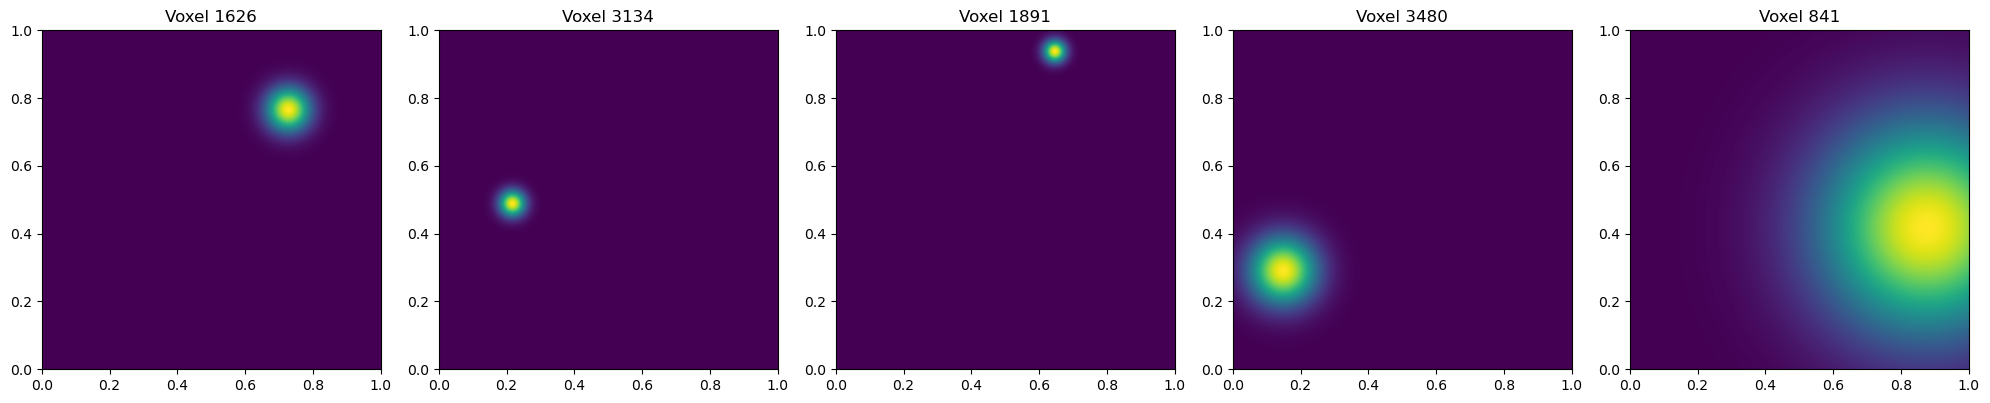

Loading PDFs for v2 from K_mat_subj1_v2.npy.npz...


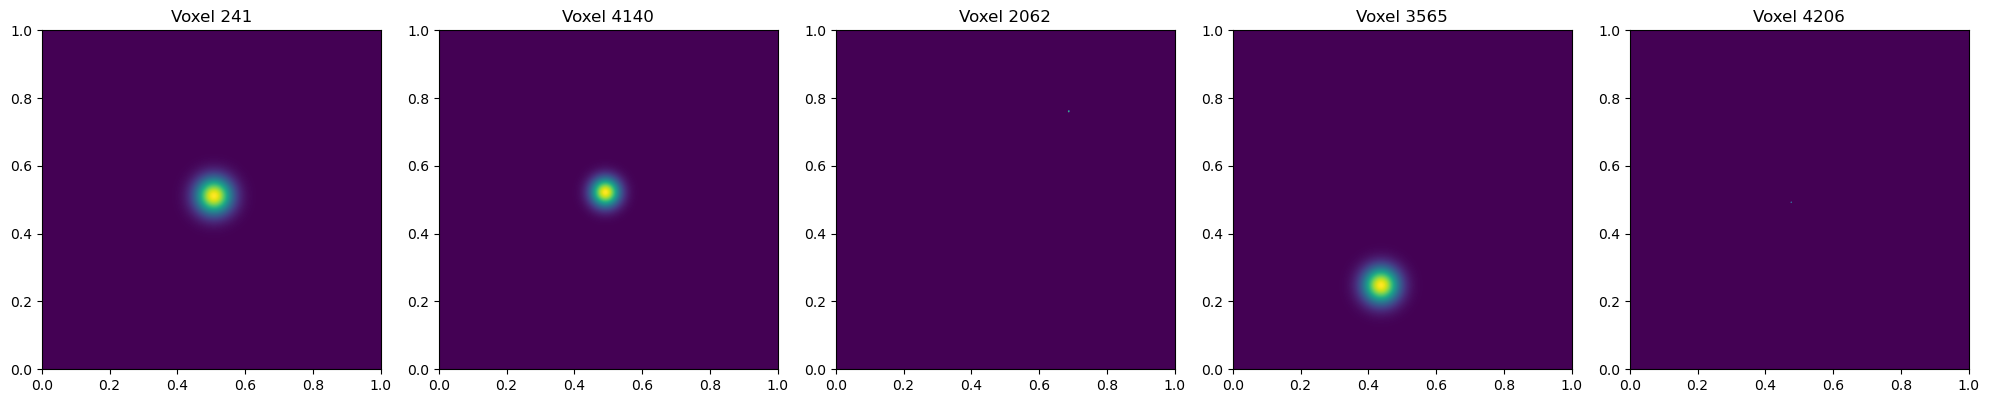

Loading PDFs for v3 from K_mat_subj1_v3.npy.npz...


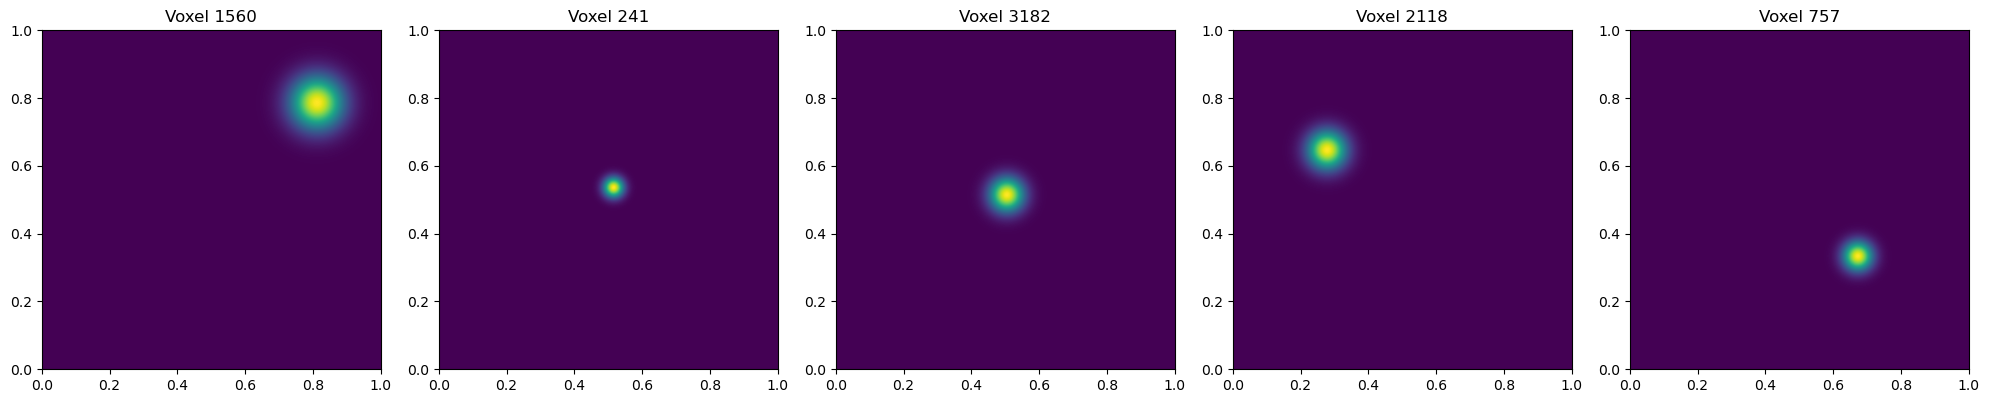

Loading PDFs for v4 from K_mat_subj1_v4.npy.npz...


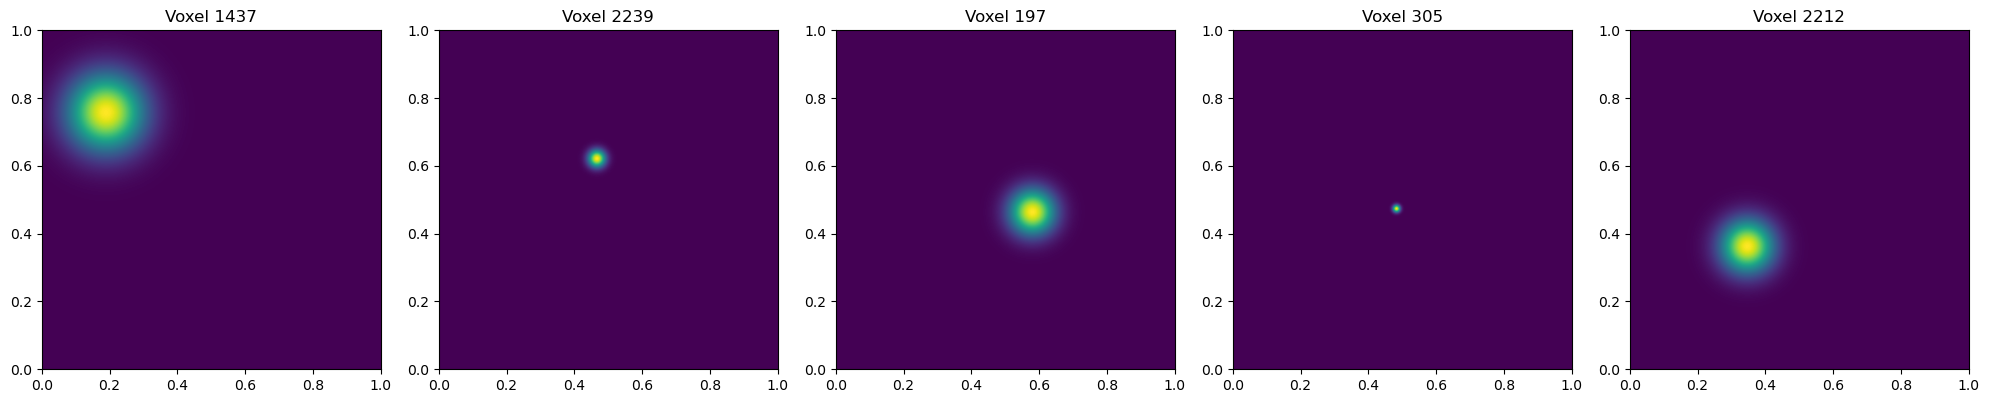

Loading PDFs for ofa from K_mat_subj1_ofa.npy.npz...


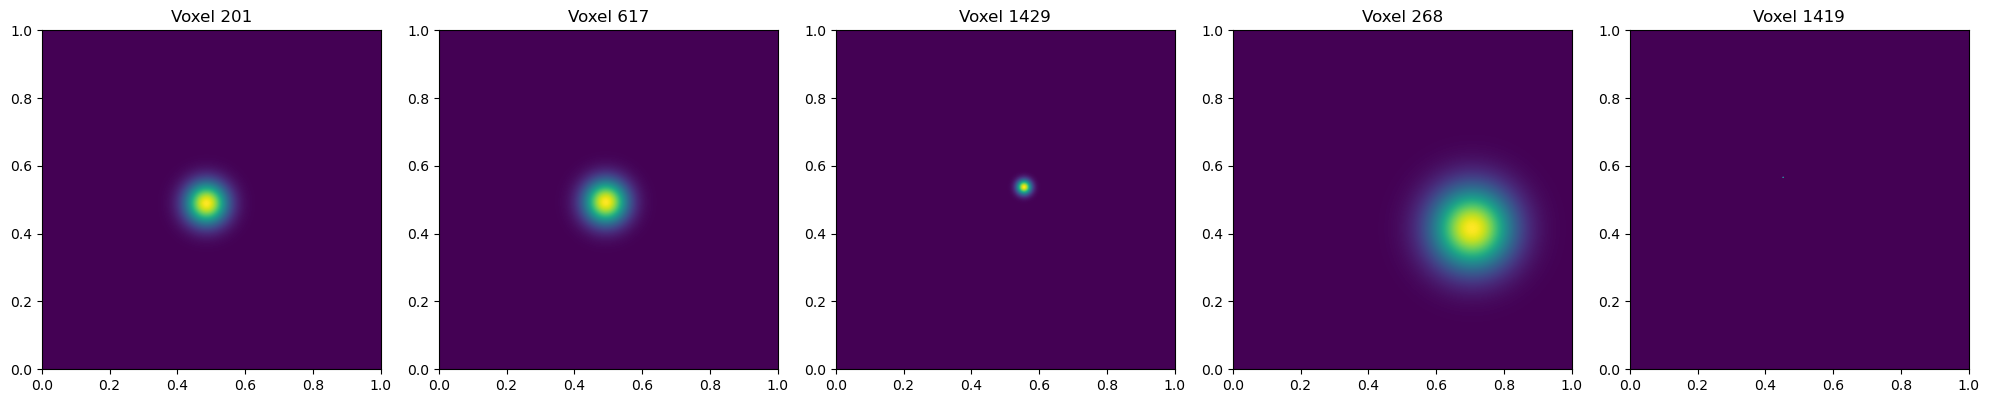

Loading PDFs for ffa1 from K_mat_subj1_ffa1.npy.npz...


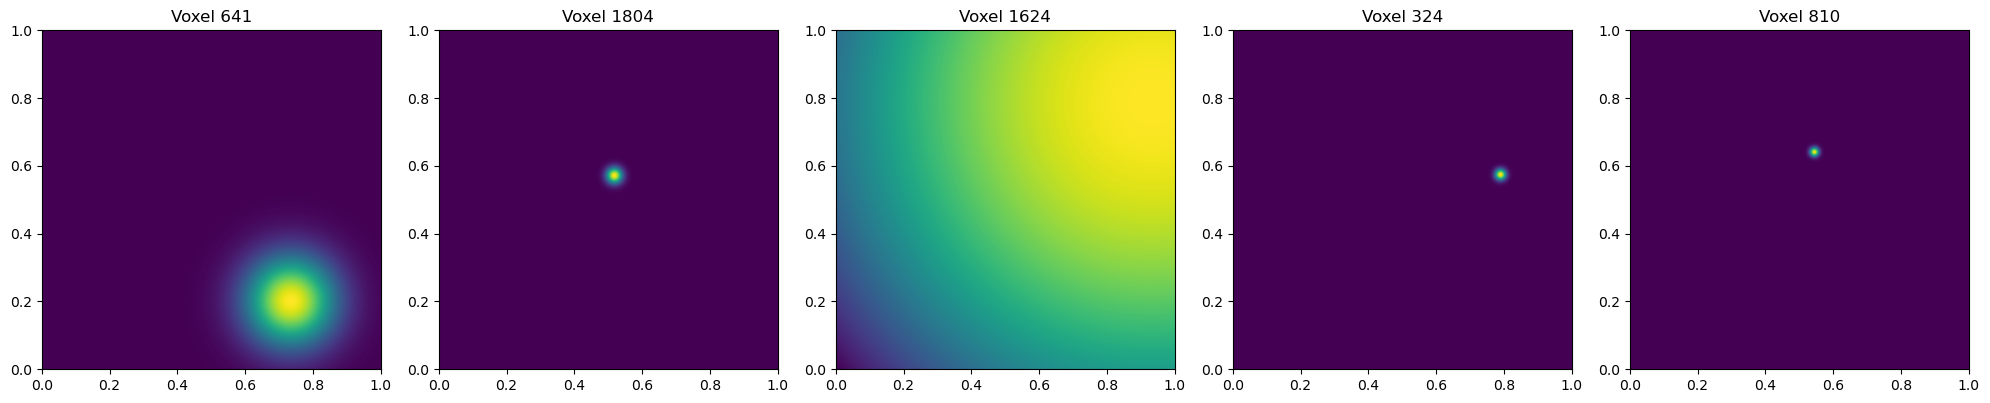

Loading PDFs for ffa2 from K_mat_subj1_ffa2.npy.npz...


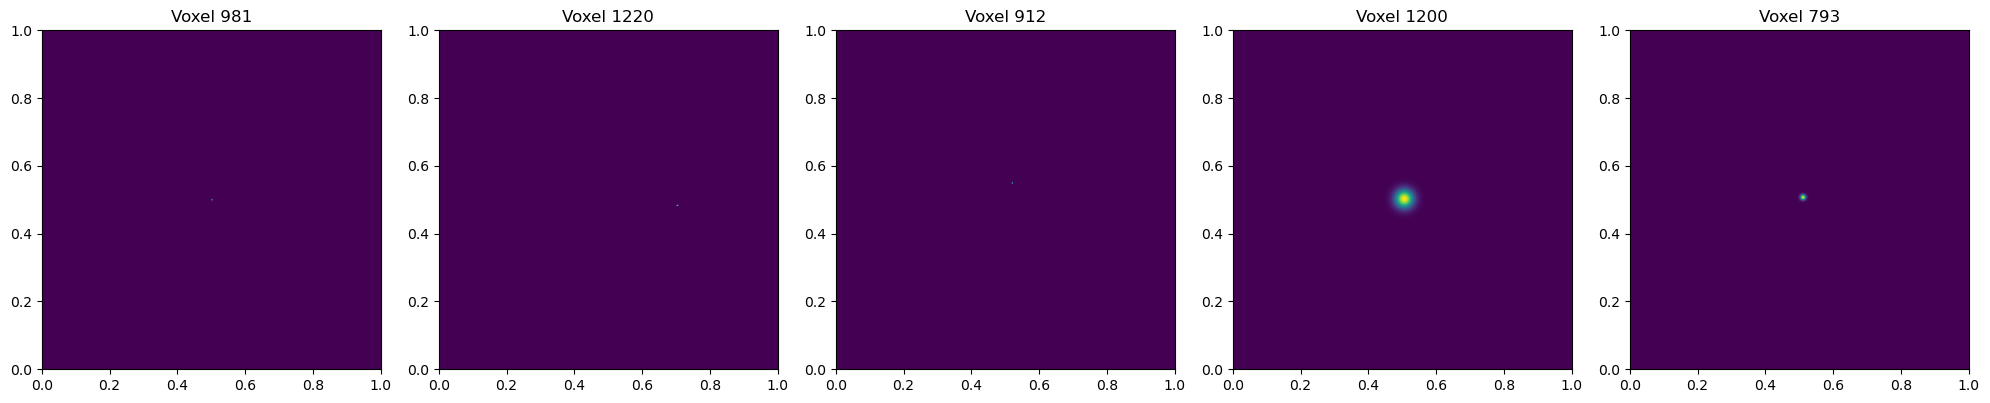

Loading PDFs for atl from K_mat_subj1_atl.npy.npz...


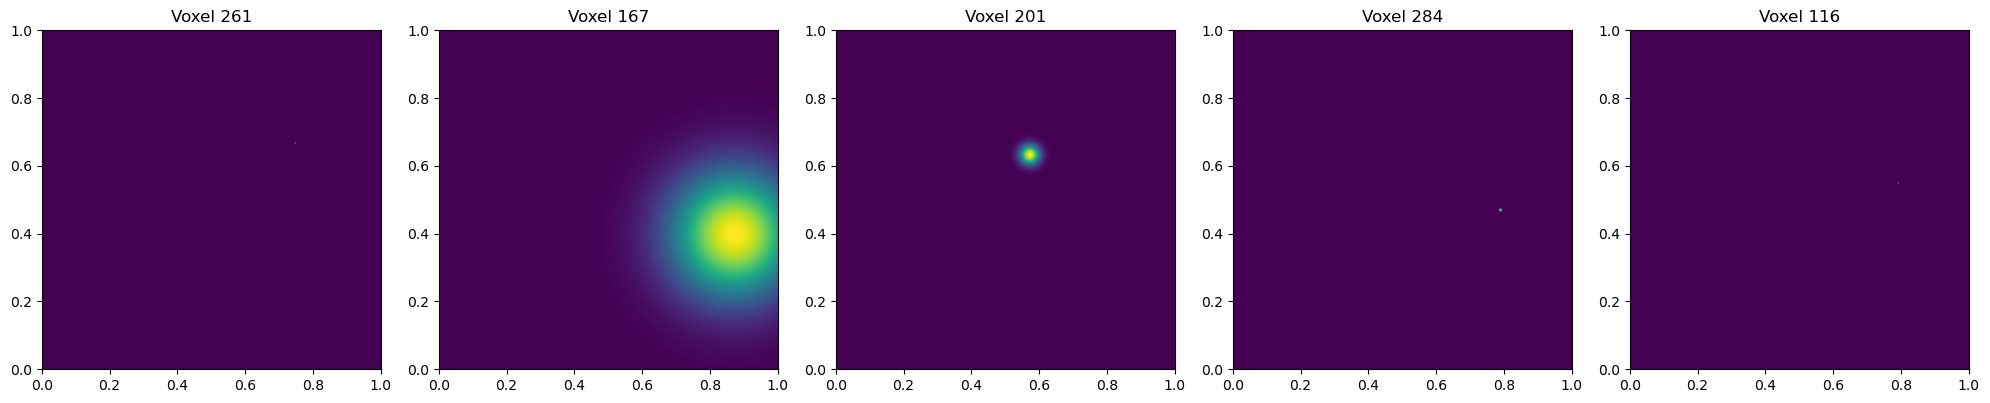

Loading PDFs for eba from K_mat_subj1_eba.npy.npz...


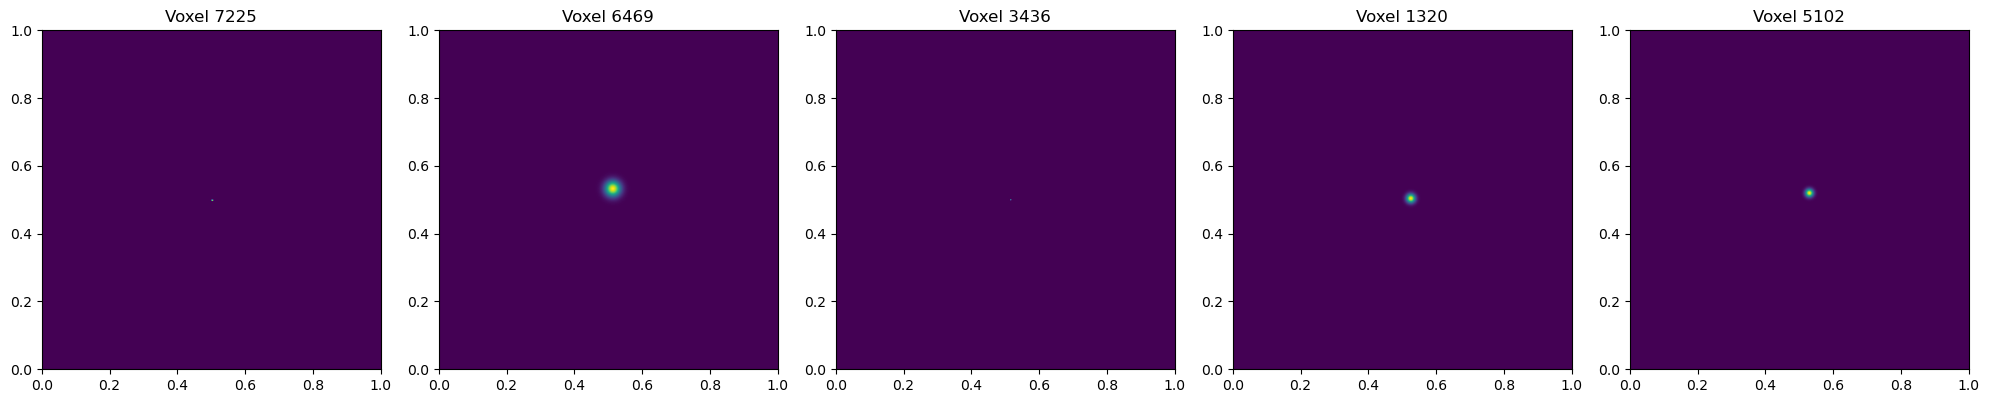

Loading PDFs for fba1 from K_mat_subj1_fba1.npy.npz...


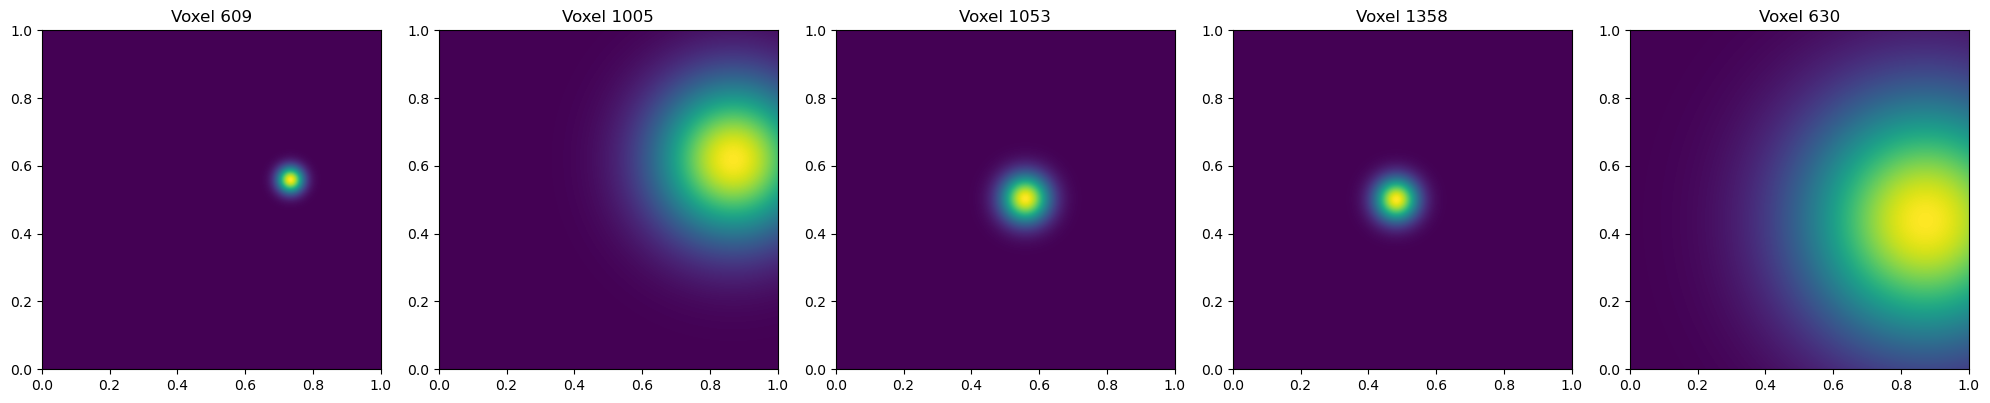

Loading PDFs for fba2 from K_mat_subj1_fba2.npy.npz...


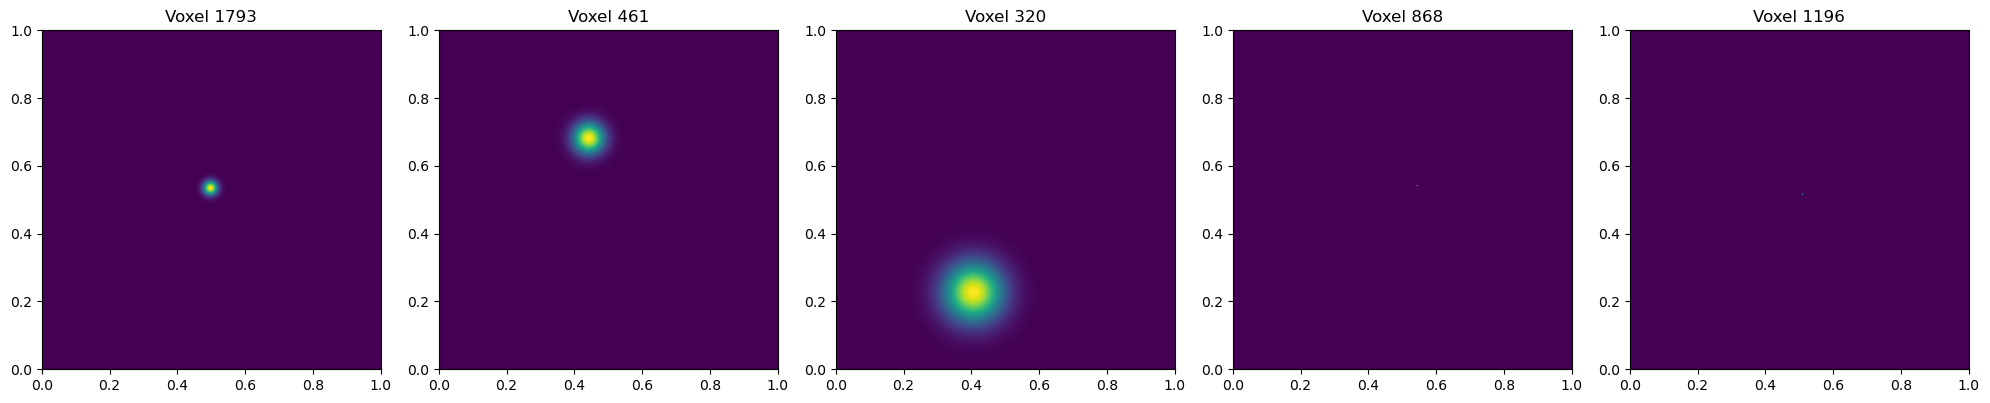

Loading PDFs for opa from K_mat_subj1_opa.npy.npz...


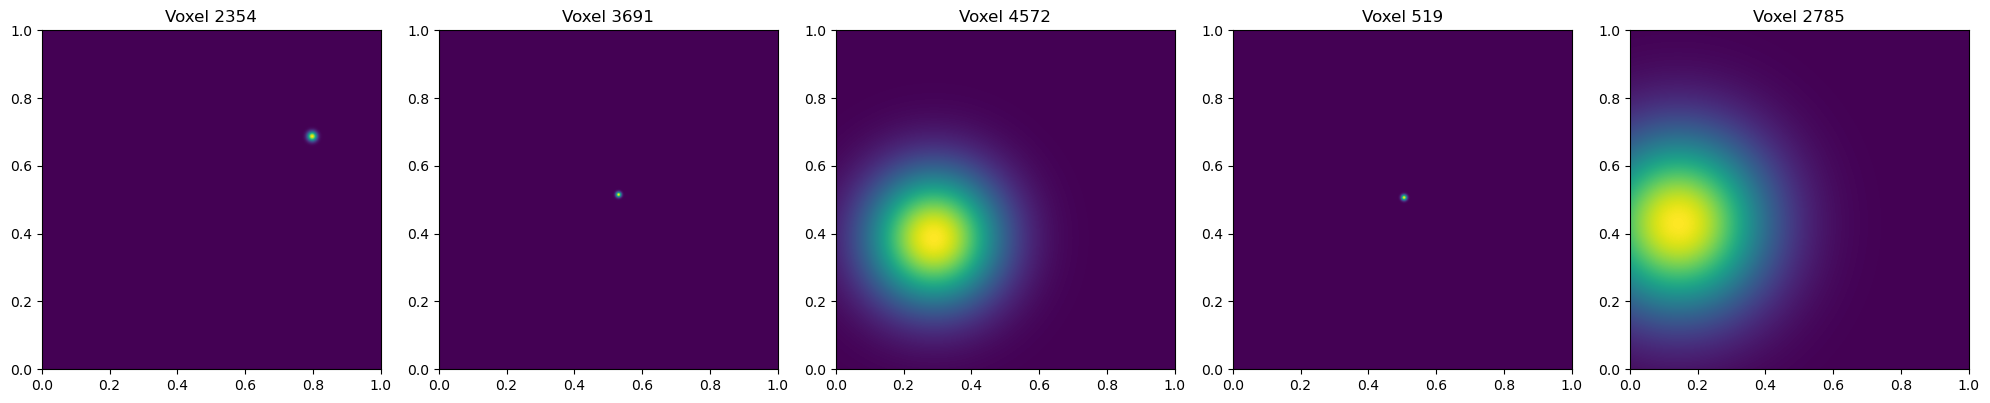

Loading PDFs for ppa from K_mat_subj1_ppa.npy.npz...


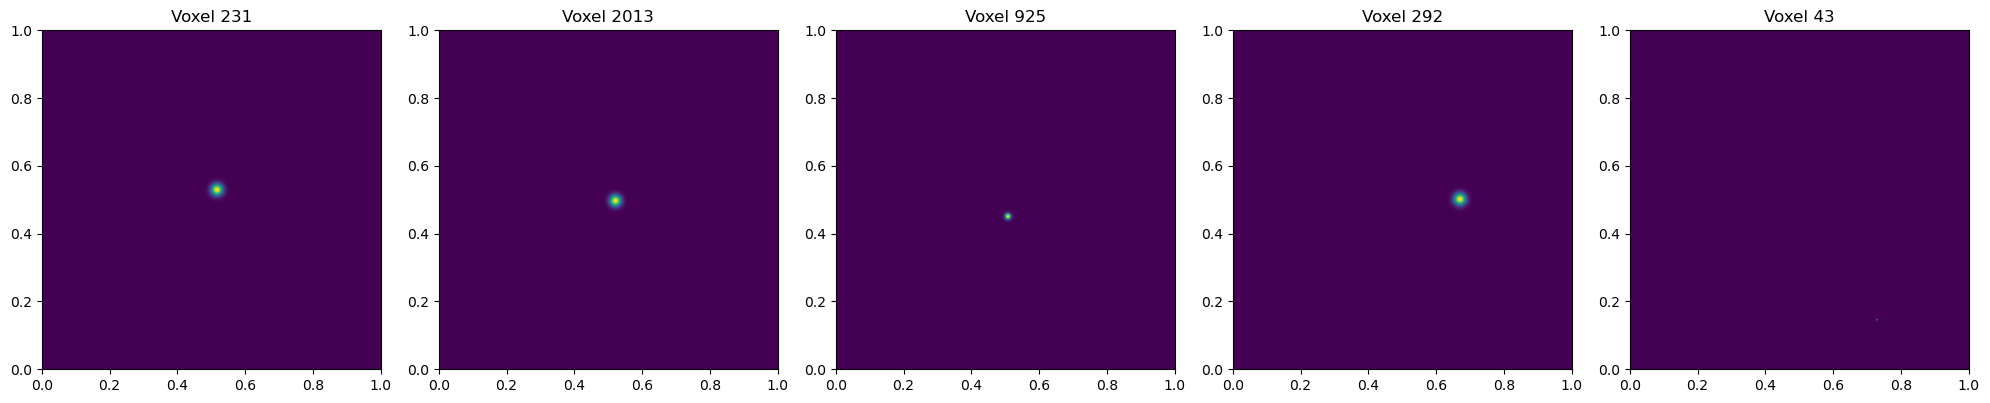

Loading PDFs for rsc from K_mat_subj1_rsc.npy.npz...


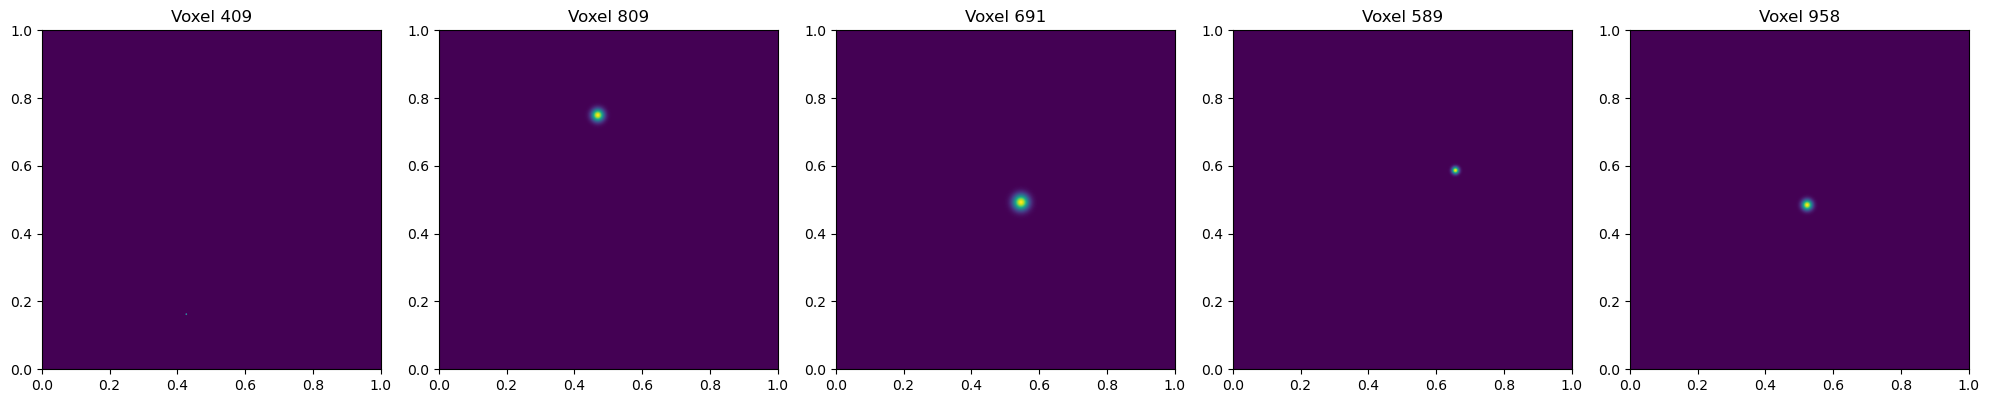

Loading PDFs for owfa from K_mat_subj1_owfa.npy.npz...


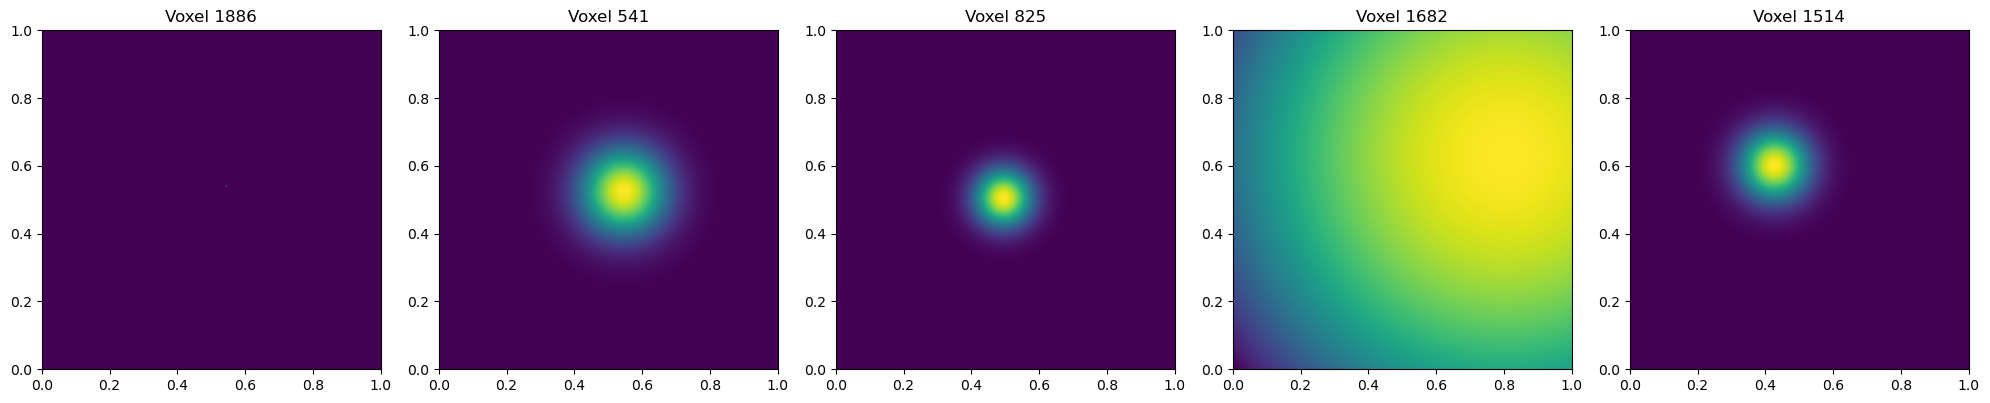

Loading PDFs for vwfa_1 from K_mat_subj1_vwfa_1.npy.npz...


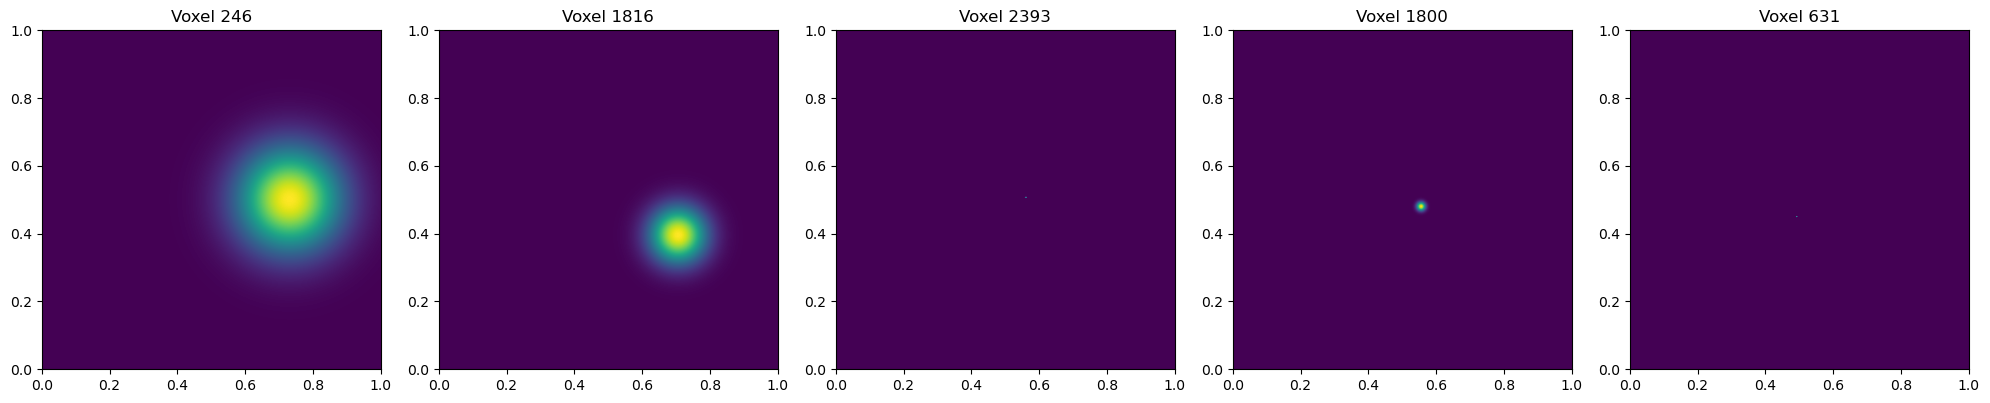

Loading PDFs for vwfa_2 from K_mat_subj1_vwfa_2.npy.npz...


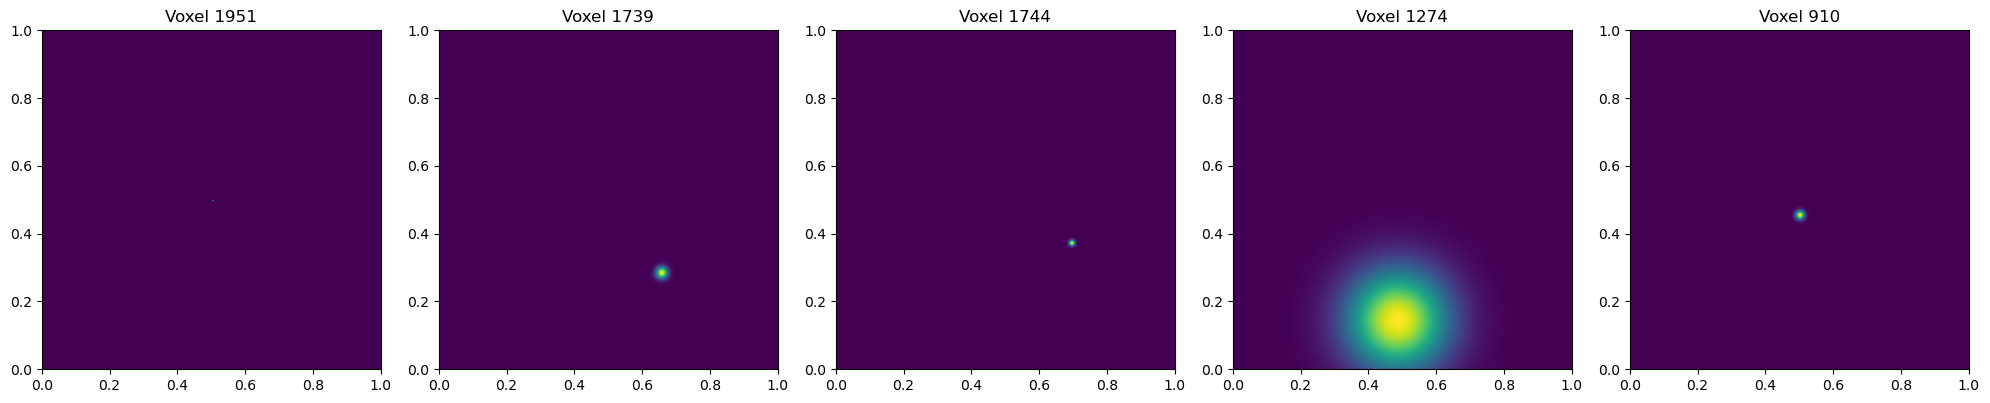

Loading PDFs for mfs_words from K_mat_subj1_mfs_words.npy.npz...


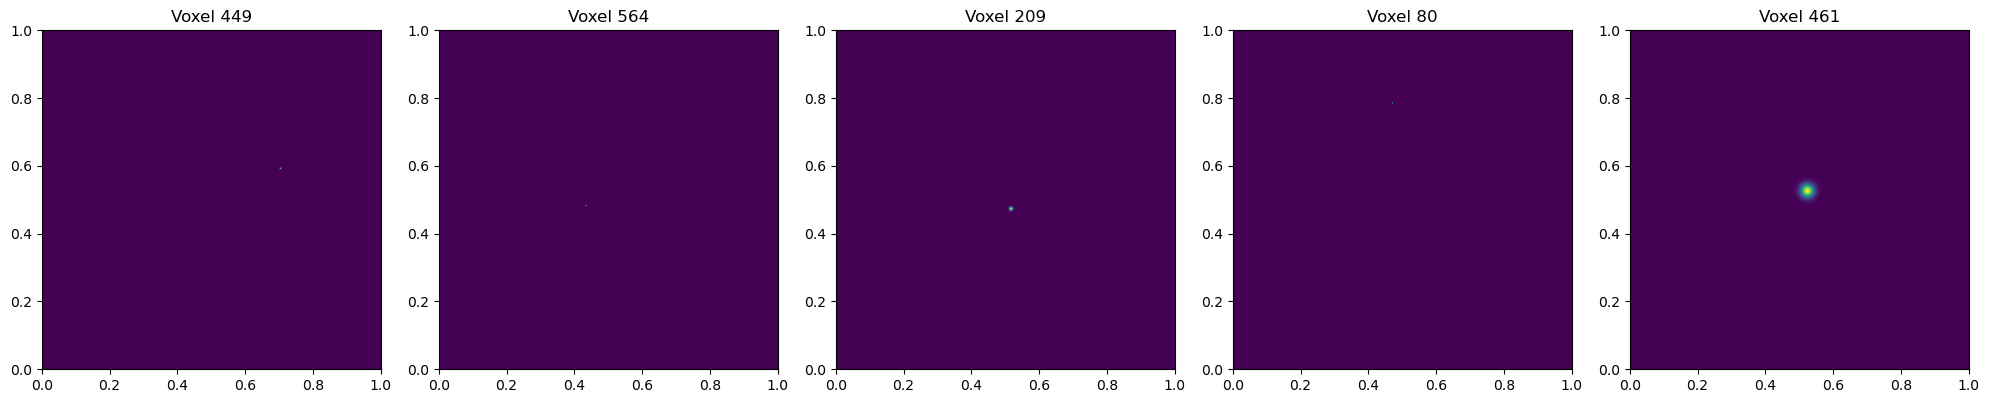

Loading PDFs for mtl_words from K_mat_subj1_mtl_words.npy.npz...


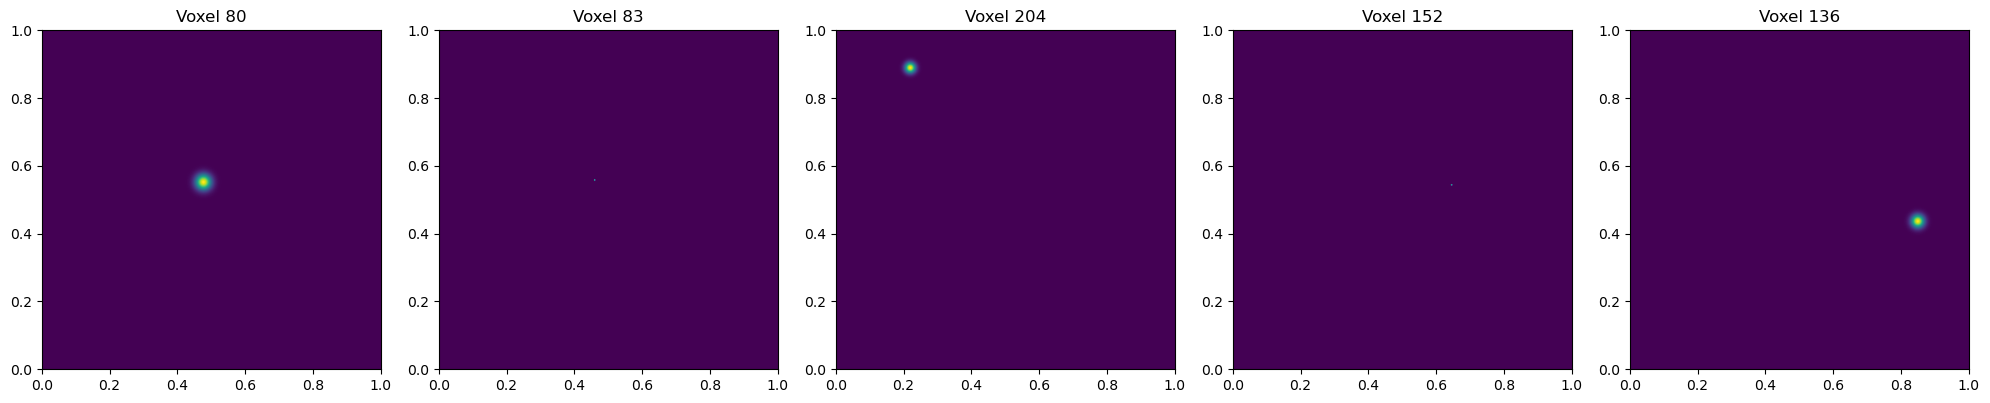

In [115]:
for roi in rois:
    plot_example_pdfs_from_roi(roi)